In [2]:
import transformers
from transformers import XLNetTokenizer, XLNetModel
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler

from torch.nn import TripletMarginLoss

import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm
from scipy.stats import spearmanr
# import mplcursors
import time
import random
import pandas as pd
import numpy as np
import warnings
import re
import json
import copy
import os
import subprocess
import shutil
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

seed = 42

torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

random.seed(seed)
np.random.seed(seed)


/home/macaulay/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Fine-Tuning BERT

In [3]:
class FineTunedBERT(nn.Module):

    def __init__(self, pool="mean", model_name= "bert-base-microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract",
                 task_type = None, n_labels = None, drop_rate = None,
                 gene2vec_flag=False, gene2vec_hidden = 200):
        
        """
            task_type : regression or classification.
        
        """
      
        super(FineTunedBERT, self).__init__()
        
        assert (task_type == 'regression' and n_labels == 1) or (task_type == 'classification' and n_labels>1) or (task_type == 'multilabel' and n_labels>1), \
            f"Invalid combination of task_type and n_labels: {task_type} and {n_labels}"  
        
        # assert gene2vec_flag is not None, f"gene2vec_flag cannot be None: {gene2vec_flag}"

        
        self.model_name = model_name
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        if "xlnet" in model_name:
            self.bert = XLNetModel.from_pretrained(model_name).to(device)
        
        else:
            self.bert = AutoModel.from_pretrained(model_name).to(device)
            
    
        self.pool = pool
        bert_hidden = self.bert.config.hidden_size
                
        
        if task_type.lower() == "classification":
            
            if gene2vec_flag:
                self.pipeline = nn.Sequential(nn.Dropout(drop_rate),
                    nn.Linear(bert_hidden+gene2vec_hidden, n_labels)
                )
                
            else:
                self.pipeline = nn.Sequential(nn.Dropout(drop_rate),
                    nn.Linear(bert_hidden, n_labels)
                )

    
        elif task_type.lower() == "multilabel":
            
            if gene2vec_flag:
                self.pipeline = nn.Sequential(nn.Dropout(drop_rate),
                    nn.Linear(bert_hidden+gene2vec_hidden, n_labels),
                    nn.Sigmoid()
                )
                
            else:
                self.pipeline = nn.Sequential(nn.Dropout(drop_rate),
                    nn.Linear(bert_hidden, n_labels),
                    nn.Sigmoid()
                )

                
        elif task_type.lower() == "regression":

            if gene2vec_flag:
                self.pipeline = nn.Sequential(nn.Dropout(drop_rate),
                nn.Linear(bert_hidden+gene2vec_hidden, 1))
                
            else:            
                self.pipeline = nn.Sequential(nn.Dropout(drop_rate),
                nn.Linear(bert_hidden, 1)
                )

        else:
            raise ValueError(f"Key Error task_type : {task_type} ")

            
        
        
    def forward(self, input_ids_, attention_mask_, gene2vec=None):
        
        
        # retrieving the hidden state embeddings
        if "xlnet" in self.model_name:
            output = self.bert(input_ids = input_ids_,
                               attention_mask=attention_mask_)

            hiddenState, ClsPooled = output.last_hidden_state, output.last_hidden_state[:,0, :]
            hiddenState, ClsPooled = hiddenState, ClsPooled


        else:
            hiddenState, ClsPooled = self.bert(input_ids = input_ids_,
                                               attention_mask=attention_mask_).values()

            
        # perform pooling on the hidden state embeddings
        if self.pool.lower() == "max":
            embeddings = self.max_pooling(hiddenState, attention_mask_)
            
        elif self.pool.lower() == "cls":
            embeddings = ClsPooled
                
        elif self.pool.lower() == "mean":
            embeddings = self.mean_pooling(hiddenState, attention_mask_)

        else:
            raise ValueError('Pooling value error.')
        
        
        if gene2vec is not None:
            embeddings = torch.cat((embeddings, gene2vec), dim=1)
      

        return embeddings, hiddenState, self.pipeline(embeddings)

    def max_pooling(self, hidden_state, attention_mask):
        
        #CLS: First element of model_output contains all token embeddings
        token_embeddings = hidden_state
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
        
        pooled_embeddings = torch.max(token_embeddings, 1)[0]
        return pooled_embeddings
    
    def mean_pooling (self, hidden_state, attention_mask):
        
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(hidden_state.size()).float()
        pooled_embeddings = torch.sum(hidden_state * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9) 
        
        return pooled_embeddings
    

def getEmbeddings(text,
                  model = None,
                  model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
                  max_length=512,
                  batch_size=1000,
                  pool ="mean"):
    

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    
    if model:
        #GeneLLM embeddings
        #model has to be trained on a task to get task specific embeddings
        model = model.to(device)
        
        if "xlnet" in model.model_name:
            tokenizer = XLNetTokenizer.from_pretrained(model.model_name)
        else:    
            tokenizer = BertTokenizerFast.from_pretrained(model.model_name)
            
    else:
        #BERT-base embeddings
        model = FineTunedBERT(pool= pool,
                              model_name=model_name,
                              task_type="classification",
                              gene2vec_flag = False,
                              n_labels = 2).to(device)
        if "xlnet" in model_name:
            tokenizer = XLNetTokenizer.from_pretrained(model_name)
        else:    
            tokenizer = BertTokenizerFast.from_pretrained(model_name)


    print("Tokenization ...")
    tokens = tokenizer.batch_encode_plus(text, max_length = max_length,
                                         padding="max_length",truncation=True,
                                         return_tensors="pt")
    
    
    dataset = TensorDataset(tokens["input_ids"] , tokens["attention_mask"])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    print("Tokenization Done.")
    
    print("Get Embeddings ...")
    
    embeddings=[]
    model.eval()
    for batch_input_ids, batch_attention_mask in tqdm(dataloader):
        with torch.no_grad():
            pooled_embeddings, _, _ = model(batch_input_ids.to(device) ,
                                            batch_attention_mask.to(device))
            embeddings.append(pooled_embeddings)
    
    
    concat_embeddings = torch.cat(embeddings, dim=0)
    
    print(concat_embeddings.size())
    
    return concat_embeddings




def getSentenceEmbeddings(sentences, max_length=512, batch_size=1000, pool ="mean"):
    
    
#     pool="mean", model_name= "bert-base-cased",
#                  task_type = None, n_labels = None, drop_rate = None,

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_name= "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
    
    model = FineTunedBERT(pool= pool,
                          model_name=model_name,
                          task_type="classification",
                          gene2vec_flag = False,
                          n_labels = 2).to(device)
    
    tokenizer = BertTokenizerFast.from_pretrained("microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract")

    print("Perform tokenization ...")
    tokens = tokenizer.batch_encode_plus(sentences, max_length = max_length,
                                         padding="max_length",truncation=True,
                                         return_tensors="pt")
    
    
    dataset = TensorDataset(tokens["input_ids"] , tokens["attention_mask"])
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    print("Tokenization Done.")
    
    print("Get embeddings ...")
    
    embeddings=[]
    model.eval()
    for batch_input_ids, batch_attention_mask in tqdm(dataloader):
        with torch.no_grad():
            pooled_embeddings, _, _ = model(batch_input_ids.to(device) ,
                                            batch_attention_mask.to(device))
            embeddings.append(pooled_embeddings)
    
    
    concat_embeddings = torch.cat(embeddings, dim=0)
    
    print(concat_embeddings.size())
    
    return concat_embeddings




def process_sent(sent):

    pattern1 = r'(?:"(.*?)"|\'(.*?)\')'
    pattern2 = r"\[provided by .*?\]"
    pattern3 = r"\(PubMed:\d+(?:\s+\d+)*\)"
    pattern4 = r"\(\s+[\w\s]+\s+[\w]+\s+\)"
    pattern5 = r"\s*\(Microbial infection\)"
    pattern6 = r"\[(Isoform [^\]]+)\]:\s*"
    pattern7 = r"\(By similarity\)"

    matches = re.findall(pattern1, sent)
    captured_content = [match[0] if match[0] else match[1] for match in matches]
    text = " ".join(captured_content)
    text = re.sub(pattern2, "", text)
    text = re.sub(pattern3, "####", text)
    text = re.sub(pattern4, "", text)
    text = re.sub(pattern5, "", text)
    text = re.sub(pattern6, r"\1 ", text)
    text = re.sub(pattern7, "", text)
    text = re.sub(r'\s+', ' ', text)
    
    return text





class MultiLabelFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(MultiLabelFocalLoss, self).__init__()
        
        self.alpha = nn.Parameter(torch.tensor(0.25, requires_grad=True, device="cuda"))  
        self.gamma = nn.Parameter(torch.tensor(2.0, requires_grad=True, device="cuda"))  

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) 
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        return F_loss.mean()





#subcell : {0:'Cytoplasm', 1:'Nucleus', 2:'Cell membrane'}
#Sol: {0:'Membrane', 1:'Soluble'}
#cons: {0:}


def plot_latent(latents, labels, epoch, class_map = None,
                task_name= "subloc", validation_type="train"):
    
    tsne = TSNE(n_components=2)
    scaler = StandardScaler()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        latents_tsne = tsne.fit_transform(latents)
    

    if class_map is not None:
        
        for i, class_label in enumerate(np.unique(labels)):
            class_indices = labels == class_label
            cl = class_map[class_label]
            plt.scatter(latents_tsne[class_indices, 0],
                        latents_tsne[class_indices, 1],
                        label=f'{cl}')
        plt.legend()
        
    else:
        plt.scatter(latents_tsne[:, 0], latents_tsne[:, 1])

        

    plt.title(f'Epoch {epoch}')
    task_path = f"data/{task_name}/"
    if not os.path.exists(task_path):
        os.makedirs(task_path)

    validation_path = f"{task_path}/{validation_type}"
    if not os.path.exists(validation_path):
        os.makedirs(validation_path)

    plt.savefig(f"{validation_path}/latent_{epoch}.png")
    plt.close()



def train(loader, model, loss_fn, optimizer, task_type= None,
          gene2vec_flag = False, device = "cuda",
          threshold=0.5 ):
    """
        task : conservation , sublocation, solubility
        task_type : regression or classification
    
    
    """
    
    train_loss = 0
    latents  = []

    total_preds = []
    total_labels = []
    
    # conservation , sublocation, solubility
   

    
    model.train()
    for batch in loader: 

        
        if gene2vec_flag:
            batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
            embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)
            
            
        else:
            batch_inputs, batch_masks , labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
            embeddings, _ , preds = model(batch_inputs, batch_masks)

        
        
        if task_type == "regression":
            
            preds = preds.squeeze().float()
            labels = labels.squeeze().float()
            
            loss = loss_fn(preds, labels) 
            
            
            total_preds.extend(preds.cpu().detach())
            total_labels.extend(labels.cpu().detach())        

        
        elif task_type == "classification":
            
            loss = loss_fn(preds, labels)
            
            total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
            total_labels.extend(labels.type(torch.int).to('cpu').numpy())

        
        
        elif task_type == "multilabel":

            preds = preds.to(torch.float32)
            labels = labels.to(torch.float32)

            loss = loss_fn(preds, labels)
            
            total_labels.extend(labels.cpu().type(torch.int).numpy().tolist())
            total_preds.extend((preds > 0.5).type(torch.int).cpu().numpy().tolist())
            
        
        train_loss += loss.item()

        
        #Aggregation
        embeddings = torch.tensor(embeddings.cpu().detach().numpy())
        latents.append(embeddings) 
        

        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss /= len(loader)
    latents = torch.cat(latents, dim=0)

    return model, train_loss, total_labels, total_preds, latents


def validation (loader, model, loss_fn, task_type = None,
                gene2vec_flag = False, device = "cuda"):
    
    val_loss = 0
    total_preds = []
    total_labels = []

    
    model.eval()
    with torch.no_grad():
        for batch in loader: 

            if gene2vec_flag:
                batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)




            else:
                batch_inputs, batch_masks , labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks)

                
                
            if task_type == "regression":
            
                preds = preds.squeeze().float()
                labels = labels.squeeze().float()

                loss = loss_fn(preds, labels)


                total_preds.extend(preds.cpu().detach())
                total_labels.extend(labels.cpu().detach())        

        
            elif task_type == "classification":

                loss = loss_fn(preds, labels)

                total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
                total_labels.extend(labels.type(torch.int).to('cpu').numpy())

            elif task_type == "multilabel":

                preds = preds.to(torch.float32)
                labels = labels.to(torch.float32)


                loss = loss_fn(preds, labels)

                total_labels.extend(labels.cpu().type(torch.int).numpy().tolist())
                total_preds.extend((preds > 0.5).type(torch.int).cpu().numpy().tolist())

            
            val_loss += loss.item()
                

    val_loss /= len(loader)

    return model, val_loss, total_labels, total_preds


def test(loader, model, loss_fn, task_type = None, gene2vec_flag = False, device = "cuda"):
    
    test_loss = 0
    total_preds = []
    total_labels = []
    latents = []

    
#     if task_type == "regression":
#         loss_fn = nn.MSELoss()
        
#     elif task_type == "classification":
#         loss_fn = nn.CrossEntropyLoss()
            
#     elif task_type == "multilabel":
# #         loss_fn = MultiLabelFocalLoss(alpha=0.25, gamma=2)
#         loss_fn = nn.BCELoss()

#     else:
#         raise ValueError(f"task type errot: {task_type}")
    
    
    model.eval()
    with torch.no_grad():
        for batch in loader: 

            if gene2vec_flag:
                batch_inputs, batch_masks, gene2vec_embeddings, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device), batch[3].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks, gene2vec = gene2vec_embeddings)
                


            else:
                batch_inputs, batch_masks, labels =  batch[0].to(device) , batch[1].to(device), batch[2].to(device)
                embeddings, _ , preds = model(batch_inputs, batch_masks)      
            
            
            if task_type == "regression":
            
                preds = preds.squeeze().float()
                labels = labels.squeeze().float()

                loss = loss_fn(preds, labels)
 

                total_preds.extend(preds.cpu().detach())
                total_labels.extend(labels.cpu().detach())        

        
            elif task_type == "classification":

                loss = loss_fn(preds, labels)

                total_preds.extend(preds.argmax(1).type(torch.int).to('cpu').numpy())
                total_labels.extend(labels.type(torch.int).to('cpu').numpy())

            
            elif task_type == "multilabel":

                preds = preds.to(torch.float32)
                labels = labels.to(torch.float32)


                loss = loss_fn(preds, labels)

                total_labels.extend(labels.cpu().type(torch.int).numpy().tolist())
                total_preds.extend((preds > 0.5).type(torch.int).cpu().numpy().tolist())

            
            test_loss += loss.item()
            

            embeddings = torch.tensor(embeddings.cpu().detach().numpy())
            latents.append(embeddings)

    test_loss /= len(loader)
    latents = torch.cat(latents, dim=0)
       
    return model, test_loss, total_labels, total_preds, latents



def process_data(genes, max_length, batch_size, val_genes = None , test_genes = None, 
                 task_type = "classification", gene2vec_flag = False,
                 model_name= "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract"):
    
    
    if "xlnet" in model_name:
        tokenizer = XLNetTokenizer.from_pretrained(model_name)

    else:    
        tokenizer = BertTokenizerFast.from_pretrained(model_name)

    
    
    sentences, labels = genes["Summary"].tolist() , genes["Label"].tolist()
    g_index, g_name = genes.index.tolist() , genes["Gene name"].tolist()
    
            

    tokens = tokenizer.batch_encode_plus(sentences, max_length = max_length,
                                         padding="max_length", truncation=True)

    data = {'input_ids': tokens["input_ids"],
            'token_type_ids': tokens["token_type_ids"],
            'attention_mask': tokens["attention_mask"],
            "labels": labels,
            "g_index": g_index,
            "g_name": g_name
           }
    
    tokens_df = pd.DataFrame(data)
    print(f"Shape of tokens_df before gene2vec:{tokens_df.shape}")
    
    #############################################
    if gene2vec_flag:
        print("Adding Gene2Vec data ...")
        
        Gene2Vec = dict()

        file_path = f'data/gene2vec_embeddings.txt'
        with open(file_path, 'r') as file:
            for line in file:

                name, embed = line.strip().split("	")
                embed = [float(value) for value in embed.split()] 

                Gene2Vec[name.strip()] = embed
                    
            
        tokens_df = tokens_df[tokens_df['g_name'].isin(set(Gene2Vec.keys()) & set(tokens_df["g_name"]))]
        
        tokens_df["gene2vec"] = tokens_df["g_name"].apply(lambda name: 
                                                          Gene2Vec[name])# if name in Gene2Vec.keys() else None )
    
    #############################################
    print(f"Shape of tokens_df after gene2vec:{tokens_df.shape}")
    
    #val_genes, test_genes,
    

    if val_genes is not None:
        val_tokens = tokens_df.loc[val_genes]
        test_tokens =  tokens_df.loc[test_genes]
        train_tokens = tokens_df.drop(val_genes+test_genes)
        
    else:
        train_tokens, test_tokens = train_test_split(tokens_df, test_size=0.15,
                                                     random_state=42)

        train_tokens, val_tokens = train_test_split(train_tokens,test_size=0.20,
                                                    random_state=42)

    

    train_tokens = train_tokens.reset_index(drop=True)
    val_tokens = val_tokens.reset_index(drop=True)
    test_tokens = test_tokens.reset_index(drop=True)
    
    if gene2vec_flag:
    
        train_dataset = TensorDataset(torch.tensor(train_tokens["input_ids"].tolist()),
                                      torch.tensor(train_tokens["attention_mask"].tolist()),
                                      torch.tensor(train_tokens["gene2vec"]),
                                      torch.tensor(train_tokens["labels"]),
                                      torch.tensor(train_tokens["g_index"]))
        
        val_dataset = TensorDataset(torch.tensor(val_tokens["input_ids"].tolist()) ,
                            torch.tensor(val_tokens["attention_mask"].tolist()),
                            torch.tensor(val_tokens["gene2vec"]),
                            torch.tensor(val_tokens["labels"]),
                            torch.tensor(val_tokens["g_index"]))
        
        test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                             torch.tensor(test_tokens["attention_mask"].tolist()),
                             torch.tensor(test_tokens["gene2vec"]),
                             torch.tensor(test_tokens["labels"]),
                             torch.tensor(test_tokens["g_index"]))
    else:
        train_dataset = TensorDataset(torch.tensor(train_tokens["input_ids"].tolist()),
                                      torch.tensor(train_tokens["attention_mask"].tolist()),
                                      torch.tensor(train_tokens["labels"]),
                                      torch.tensor(train_tokens["g_index"]))
        
        val_dataset = TensorDataset(torch.tensor(val_tokens["input_ids"].tolist()) ,
                            torch.tensor(val_tokens["attention_mask"].tolist()),
                            torch.tensor(val_tokens["labels"]),
                            torch.tensor(val_tokens["g_index"]))
        
        test_dataset = TensorDataset(torch.tensor(test_tokens["input_ids"].tolist()),
                             torch.tensor(test_tokens["attention_mask"].tolist()),
                             torch.tensor(test_tokens["labels"]),
                             torch.tensor(test_tokens["g_index"]))
        
        
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    return train_loader, val_loader, test_loader



def get_metrics(y_true , y_pred, history,  val_type = "Train",
                task_type = "classification"):
    
    
    if task_type == "classification" or task_type == "multilabel":
    
        average = "samples" if task_type == "multilabel" else "weighted"
    
        acc= accuracy_score(y_true , y_pred)
        f1 = f1_score(y_true , y_pred, average=average, zero_division=np.nan)
        prec = precision_score(y_true , y_pred, average=average, zero_division=np.nan)
        rec = recall_score(y_true , y_pred, average=average, zero_division=np.nan)

        history[val_type]["Accuracy"].append(acc)
        history[val_type]["F1"].append(f1)
        history[val_type]["Precision"].append(prec)
        history[val_type]["Recall"].append(rec)
        
        return acc, f1 , prec , rec
        
    else:
        
        
        corrcoef = spearmanr(y_true, y_pred)[0]
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)        
        
        history[val_type]["Correlation"].append(corrcoef)
        history[val_type]["MAE"].append(mae)
        history[val_type]["MSE"].append(mse)
        history[val_type]["R2"].append(r2)
        
        return corrcoef, mae, mse, r2


def process_Go_data(path):
    
    
    df = pd.read_csv(path)
    
    df["Gene Name"] = df.index
    df = df.melt(id_vars=["Gene Name"], var_name="GO Term", value_name="Gene Names")


    df = df.dropna(subset=["Gene Names"])

    df = df.reset_index(drop=True)

    gene_ontology_dict = {}

    for _, row in df.iterrows():
        gene_name = row["Gene Names"]
        go_term = row["GO Term"]

        if gene_name not in gene_ontology_dict:
            gene_ontology_dict[gene_name] = [go_term]
        else:
            gene_ontology_dict[gene_name].append(go_term)

            
    
    for gene_name, go_terms in gene_ontology_dict.items():
        if len(go_terms) == 1:
            gene_ontology_dict[gene_name] = go_terms

            
    
    knownGenes = []
    for i in range (14):
        file_path = f'data/knownGenes/GeneLLM_all_cluster{i}.txt'
        with open(file_path, 'r') as file:
            for line in file:
                knownGenes.append(line.strip()) 
                

    genes = pd.read_csv("data/genes.csv")
    genes["Summary"] = genes["Summary"].apply(lambda sent: process_sent(sent))
    genes = genes.drop_duplicates(subset='Summary')
    genes = genes[genes['Gene name'].isin(knownGenes)]

    genes["StrLabel"] = genes["Gene name"].apply(lambda name: gene_ontology_dict.get(name,None))
    
    genes_go = genes.dropna(subset=["StrLabel"]).reset_index(drop=True)  

    
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(genes_go['StrLabel'])
    
    genes_go["Label"] = labels.tolist() 
    
    return genes_go, len(mlb.classes_)


def plot_GO_accuracy_histogram(labels, preds, level=2):
    
    labels = np.array(labels)
    preds = np.array(preds)
    
    n_classes = labels.shape[1]
    accuracies = [accuracy_score(labels[:, i], preds[:, i]) for i in range(n_classes)]
    bars = plt.bar(range(n_classes), accuracies)
    plt.xlabel('GO Term')
    plt.ylabel('Accuracy')
    plt.title(f'Level {level}: GO Terms')
    plt.xticks(ticks=range(n_classes), labels=[f'{i+1}' for i in range(n_classes)])
    
#     for bar, acc in zip(bars, accuracies):
#         yval = bar.get_height() -0.5
#         plt.text(bar.get_x() + bar.get_width()/2, yval,
#                  f'{acc:.2f}', ha='center', va='center', rotation='vertical')

    plt.show()


def trainer(epochs, genes, train_loader, val_loader, test_loader,
                lr = 1e-5, pool = "cls", max_length= 100, batch_size =100, drop_rate =0.1,
                gene2vec_flag = False, gene2vec_hidden = 200, device = "cuda",
                task_type = "classification", n_labels = 3 , model_name= "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract", task_name = 'Subcellular_location'):
    
    
    """
        gene2vec_flag: if True then, the embeddings of gene2vec will be concat to GeneLLM embeddings.

        model_name: "xlnet-base-cased",
                    "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract",
                    "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
                    "dmis-lab/biobert-base-cased-v1.1",
                    "bert-base-cased",
                    "bert-base-uncased"


        task_type = classification or regression
    
    
    """
    
    

    #subcell : {0:'Cytoplasm', 1:'Nucleus', 2:'Cell membrane'}
    #Sol: {0:'Membrane', 1:'Soluble'}
    #cons: {0:}
    global class_map
    if task_type == "classification":
        history = {
            "Train":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[]},
            "Val":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[]},
            "Test":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[]}}
        
        unique_values = genes.iloc[:, 3].unique()
        
        class_map = {i: value for i, value in enumerate(unique_values)}
        print ("\n#############################")
        print (f"Currently running {task_name}.")
        print ("#############################\n")


    elif task_type == "multilabel":
        history = {
            "Train":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[]},
            "Val":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[]},
            "Test":{"Accuracy":[], "F1":[], "Precision":[], "Recall":[]}}
        
            
        print ("\n#############################")
        print ("Currently running {task_name}.")
        print ("#############################\n")          



    elif task_type == "regression":
        history = {
            "Train":{"Correlation":[]}, "Val":{"Correlation":[]}, "Test":{"Correlation":[]}}
        
        if n_labels == 1:
            
            class_map = None
            print ("\n###############################")
            print (f"Currently running {task_name}.")
            print ("###############################\n")
        
    

    if task_type == "regression":
        loss_fn = nn.MSELoss()
        
    elif task_type == "classification":
        loss_fn = nn.CrossEntropyLoss()
        
    elif task_type == "multilabel":
        loss_fn = MultiLabelFocalLoss()
        # loss_fn = nn.BCELoss()
    else:
        raise ValueError(f"task type error: {task_type}")




    model = FineTunedBERT(pool= pool, task_type = task_type, n_labels = n_labels,
                          drop_rate = drop_rate, model_name = model_name,
                          gene2vec_flag= gene2vec_flag,
                          gene2vec_hidden = gene2vec_hidden).to(device)
    
    optimizer = AdamW(model.parameters(), lr=lr)
    
#     train_loader, val_loader, test_loader = process_data_sub(genes, max_length, batch_size,
#                                                              gene2vec_flag = gene2vec_flag,
#                                                              model_name = model_name)
    
    best_pred = None
    optimal_acc = -1
    global best_model_state
    best_model_state = None
    best_val_metric = 0.0 if task_type in ["classification", "multilabel"] else float('-inf')




    
    
    for epoch in range(epochs):
        start_time = time.time()
        
        print(f"Epoch {epoch+1} of {epochs}")
        print("-------------------------------")
        
        print("Training ...")
        
        model, train_loss, labels_train, pred_train, latents = train(train_loader, model, loss_fn, optimizer,
                                                                     task_type = task_type,
                                                                     gene2vec_flag = gene2vec_flag,
                                                                     device = device)
        print(latents.size())
        plot_latent(latents, labels_train,  epoch, class_map, task_name, validation_type="train")
        
        
        
        print("Validation ...")
        model, val_loss, labels_val, pred_val  = validation (val_loader, model, loss_fn,
                                                             task_type = task_type,
                                                             gene2vec_flag = gene2vec_flag,
                                                             device = device)
        
        print("Testing ...")
        model, test_loss, labels_test, pred_test, _ = test (test_loader, model, loss_fn,
                                                            task_type = task_type,
                                                            gene2vec_flag = gene2vec_flag,
                                                           device = device)
        

        metrics_train  = get_metrics(labels_train , pred_train, history,
                                      val_type = "Train", task_type = task_type)
        
        metrics_val = get_metrics(labels_val , pred_val, history,
                                  val_type = "Val",task_type = task_type)
    
        
        

        metrics_test = get_metrics(labels_test , pred_test, history, val_type = "Test",
                                   task_type = task_type)

        if task_type == "classification" or task_type == "multilabel":
            acc_train, f1_train, prec_train, rec_train = metrics_train
            acc_val, f1_val, prec_val, rec_val = metrics_val
            acc_test, f1_test, prec_test, rec_test = metrics_test

            

            print(f'\tET: {round(time.time() - start_time,2)} Seconds')
            print(f'Train Loss: {round(train_loss,4)}, Accuracy: {round(acc_train,4)}, F1: {round(f1_train,4)}, Precision: {round(prec_train,4)}, Recall: {round(rec_train,4)}')
            print(f'Val Loss: {round(val_loss,4)}, Accuracy: {round(acc_val,4)}, F1: {round(f1_val,4)}, Precision: {round(prec_val,4)}, Recall: {round(rec_val,4)}')
            print(f'Test Loss: {round(test_loss,4)}, Accuracy: {round(acc_test,4)}, F1: {round(f1_test,4)}, Precision: {round(prec_test,4)}, Recall: {round(rec_test,4)}')
    
            with open(f'data/{task_name}/metrics_{task_name}.csv', 'a') as f:
                if epoch == 0:
                    f.write("epoch,train_loss,train_acc,train_f1,train_prec,train_rec,val_loss,val_acc,val_f1,val_prec,val_rec,test_loss,test_acc,test_f1,test_prec,test_rec\n")
                f.write(f"{epoch+1},{train_loss},{acc_train},{f1_train},{prec_train},{rec_train},{val_loss},{acc_val},{f1_val},{prec_val},{rec_val},{test_loss},{acc_test},{f1_test},{prec_test},{rec_test}\n")
        else:
            
            train_corr = metrics_train
            val_corr = metrics_val
            test_corr = metrics_test
            
            print(f'\tET: {round(time.time() - start_time,2)} Seconds')
            print(f'\tTrain Loss: {round(train_loss,4)}, corrcoef: {round(train_corr,4)}')
            print(f'\tVal Loss: {round(val_loss,4)}, corrcoef: {round(val_corr,4)}')
            print(f'\tTest Loss: {round(test_loss,4)}, corrcoef: {round(test_corr,4)}')
            
            with open(f'data/{task_name}/metrics_{task_name}.csv', 'a') as f:
                if epoch == 0:
                    f.write(f"epoch,train_loss,train_corr,val_loss,val_corr,test_loss,test_corr\n")
                f.write(f"{epoch+1},{train_loss},{train_corr},{val_loss},{val_corr},{test_loss},{test_corr}\n")



        current_val_metric = val_corr if task_type == "regression" else acc_val  
        if current_val_metric > best_val_metric:
            best_val_metric = current_val_metric
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, f'data/{task_name}/best_model_{task_name}.pth')
            global best_epoch_num
            best_epoch_num = epoch + 1
            print(f'best_epoch_num: {best_epoch_num}')

        #plot the losses and accuracies till best epoch
        if epoch == len(range(epochs))-1:
            if task_type == "regression":
                df_corr = pd.read_csv(f'data/{task_name}/metrics_{task_name}.csv')
                df_filtered = df_corr[df_corr['epoch'] <= best_epoch_num]
                plt.figure(figsize=(12, 5))

                # Plot for Loss
                plt.subplot(1, 2, 1)
                plt.plot(df_filtered['epoch'], df_filtered['train_loss'], label='Train Loss', marker='o')
                plt.plot(df_filtered['epoch'], df_filtered['val_loss'], label='Validation Loss', marker='o')
                plt.plot(df_filtered['epoch'], df_filtered['test_loss'], label='Test Loss', marker='o')
                plt.title('Loss across Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True)

                # Plot for Correlation Coefficients
                plt.subplot(1, 2, 2)
                plt.plot(df_filtered['epoch'], df_filtered['train_corr'], label='Train Correlation', marker='o')
                plt.plot(df_filtered['epoch'], df_filtered['val_corr'], label='Validation Correlation', marker='o')
                plt.plot(df_filtered['epoch'], df_filtered['test_corr'], label='Test Correlation', marker='o')
                plt.title('Correlation Coefficients across Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Correlation Coefficient')
                plt.legend()
                plt.grid(True)
                plt.savefig(f'data/{task_name}/finetuning_loss_{task_name}.png')

                plt.tight_layout()
                plt.show()

            elif task_type == "classification" or task_type == "multilabel":
                df = pd.read_csv(f'data/{task_name}/metrics_{task_name}.csv')
                df_filtered = df[df['epoch'] <= best_epoch_num]
                plt.figure(figsize=(12, 5))

                # Plot for Loss
                plt.subplot(1, 2, 1)
                plt.plot(df_filtered['epoch'], df_filtered['train_loss'], label='Train Loss', marker='o')
                plt.plot(df_filtered['epoch'], df_filtered['val_loss'], label='Validation Loss', marker='o')
                plt.plot(df_filtered['epoch'], df_filtered['test_loss'], label='Test Loss', marker='o')
                plt.title('Loss across Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True)

                # Plot for Accuracy
                plt.subplot(1, 2, 2)
                plt.plot(df_filtered['epoch'], df_filtered['train_acc'], label='Train Accuracy', marker='o')
                plt.plot(df_filtered['epoch'], df_filtered['val_acc'], label='Validation Accuracy', marker='o')
                plt.plot(df_filtered['epoch'], df_filtered['test_acc'], label='Test Accuracy', marker='o')
                plt.title('Accuracy across Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid(True)
                plt.savefig(f'data/{task_name}/finetuning_loss_{task_name}.png')
                plt.tight_layout()
                plt.show()
                



            


    return history, labels_test, best_pred
            

def save_finetuned_embeddings(genes, pool = "cls", max_length= 100, batch_size =100, drop_rate =0.1,
                gene2vec_flag = False, gene2vec_hidden = 200, device = "cuda",
                task_type = "classification", n_labels = 3 , model_name= "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract", task_name = 'Subcellular_location'): 

    model = FineTunedBERT(pool= pool, task_type = task_type, n_labels = n_labels,
                          drop_rate = drop_rate, model_name = model_name,
                          gene2vec_flag= gene2vec_flag,
                          gene2vec_hidden = gene2vec_hidden).to(device)
    
    # optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    state_dict = torch.load(f'data/{task_name}/best_model_{task_name}.pth')
    model.load_state_dict(state_dict)

    # Tokenize the gene summaries
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    encoded_summaries = tokenizer.batch_encode_plus(genes["Summary"].tolist(), 
                                                   max_length=max_length, 
                                                   padding="max_length",
                                                   truncation=True,
                                                   return_tensors="pt")

    # DataLoader for all genes
    all_dataset = TensorDataset(encoded_summaries["input_ids"], encoded_summaries["attention_mask"])
    all_data_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=False)

    # Store gene names separately
    all_gene_names = genes["Gene name"].tolist()

    # Get embeddings for all genes
    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for idx, (inputs, masks) in enumerate(all_data_loader):
            embeddings, _, _ = model(inputs.to(device), masks.to(device))
            all_embeddings.append(embeddings.cpu().numpy())

    # Flatten embeddings list
    all_embeddings = np.vstack(all_embeddings)

    
    embeddings_filename = f'data/{task_name}/fine_tuned_embeddings_{task_name}.csv'
    embeddings_df = pd.DataFrame(all_embeddings)
    embeddings_df['gene_name'] = all_gene_names  

    
    embeddings_df.to_csv(embeddings_filename, index=False)
 

    embeddings_df = pd.concat([embeddings_df.iloc[:, -1], embeddings_df.iloc[:, :-1]], axis=1)
    embeddings_df.columns = [''] * len(embeddings_df.columns)
    embeddings_filename = f'data/{task_name}/fine_tuned_embeddings_{task_name}.csv'
    embeddings_df.to_csv(embeddings_filename, header=False, index=False)
    print(f'Fine-tuned embeddings saved to {embeddings_filename}')
    print(f'best epoch number: {best_epoch_num}')








def loading_data(input_data_path = 'data/subcellular_location.csv', task_type = "classification"):

    if task_type == 'multilabel':
        genes_datas, n_labels = process_Go_data(input_data_path)

        return genes_datas, n_labels

    else:

        knownGenes = []
        for i in range (14):
            file_path = f'data/knownGenes/GeneLLM_all_cluster{i}.txt'
            with open(file_path, 'r') as file:
                for line in file:
                    knownGenes.append(line.strip()) 


        input_data = pd.read_csv(input_data_path)
        gene_name = input_data.columns[0]
        # global task_name
        column_name = input_data.columns[1]
        labels_dict = input_data.set_index(gene_name)[column_name].to_dict()


        genes = pd.read_csv("data/genes.csv")
        genes["Summary"] = genes["Summary"].apply(lambda sent: process_sent(sent))
        genes = genes.drop_duplicates(subset='Summary')
        genes = genes[genes['Gene name'].isin(knownGenes)]

        if task_type == "classification":

            genes[column_name] = genes["Gene name"].apply(lambda name: labels_dict.get(name,None))

            genes_loc = genes.dropna(subset=[column_name]).reset_index(drop=True)

            labels, uniques = pd.factorize(genes_loc[column_name])
            label_dict = dict(zip(uniques, range(len(uniques))))
            n_labels = len(uniques)
            

            genes_loc["Label"] = genes_loc[column_name].map(label_dict)

            #print(genes_loc.Label.value_counts())
        
            return genes_loc, n_labels

        elif task_type == "regression":
            genes["Label"] = genes["Gene name"].apply(lambda name: labels_dict.get(name,None))
            genes_datas = genes.dropna(subset=["Label"]).reset_index(drop=True)
            n_labels = 1

            return genes_datas, n_labels
        







def Logistic_Regression(task_name, finetuned_emb_path, input_data_path):


    df_ft = pd.read_csv(finetuned_emb_path)
    df_ft_label = pd.read_csv(input_data_path)

    ####################################################################################################################################
    # gene_solu_emb.columns = ['GeneSymbol'] + [f'Col_{i}' for i in range(1, len(gene_solu_emb.columns))]

    # merged_data = df_ft.merge(df_ft_label, left_on='gene_name', right_on='GeneSymbol', how='inner')


    df_ft.columns = ['GeneSymbol'] + [f'Col_{i}' for i in range(1, len(df_ft.columns))]
    merged_data = pd.merge(df_ft_label, df_ft, on='GeneSymbol', how='left').dropna()
    # import sys



    # Assuming merged_data is loaded beforehand
    X = merged_data.iloc[:, 2:]
    y = merged_data.iloc[:, 1:2]

    # sys.exit("Exiting the code at a specific point.")
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Instantiate the model with the best parameters
    model = LogisticRegression(C=1, max_iter=1000)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict the test set results
    y_pred = model.predict(X_test)

    joblib.dump(model, f"data/{task_name}/logistic_regression_model_{task_name}.pkl")

    # Print the accuracy
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

    # Print the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix: \n {conf_mat}")

    # Print the classification report
    print(f"Classification Report: \n {classification_report(y_test, y_pred)}")

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_mat, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix', size=15)
    plt.savefig(f'data/{task_name}/confusion_matrix_LR.png')
    plt.show()

    # Calculate the probabilities
    probabilities = model.predict_proba(X_test)

    # Create a label encoder instance
    label_encoder = LabelEncoder()

    # Fit the encoder on the entire target data
    label_encoder.fit(y)

    # Transform y_test and y_pred to binary or multi-class format
    encoded_y_test = label_encoder.transform(y_test)

    # Check the number of unique labels
    # unique_values = y['Solubility'].unique()
    unique_labels = y[f'{y.columns[0]}'].unique()

    if len(unique_labels) == 2:
        # Binary classification
        fpr, tpr, _ = roc_curve(encoded_y_test, probabilities[:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.savefig(f'data/{task_name}/ROC_AUC_CURVE_LR.png')

        plt.show()

    else:
        # Multi-class classification
        # One-vs-all ROC AUC curves
        n_classes = len(unique_labels)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve((encoded_y_test == i).astype(int), probabilities[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot all ROC curves
        plt.figure()
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.savefig(f'data/{task_name}/ROC_AUC_CURVE_LR.png')

        plt.show()




















def analyze(input_data_path, task_type, task_name):

    #########################################----------Prepare Data----------------######################################################################


    gene_loaded_data, n_labels = loading_data(input_data_path, task_type)
    print(f'Number of {task_name} labels: {n_labels}')
    display(gene_loaded_data)

    #########################################----------Create necessary directories----------------######################################################################
    if os.path.exists(f"data/{task_name}"):
        shutil.rmtree(f"data/{task_name}")
    if os.path.exists(f"data/{task_name}/enrichment_analysis"):
        shutil.rmtree(f"data/{task_name}/enrichment_analysis")

    os.makedirs(f"data/{task_name}", exist_ok=True)
    os.makedirs(f"data/{task_name}/enrichment_analysis", exist_ok=True)

    ##############################################----------------Split to test & val----------------######################################################################################

    max_length = 512
    batch_size = 40

    train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size, gene2vec_flag = False, model_name = "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract")
    val_genes = val_loader.dataset.tensors[-1]
    test_genes = test_loader.dataset.tensors[-1]

    data_dict = {
        "val": val_genes.tolist(),
        "test": test_genes.tolist()
    }

    json_file_path = f"data/{task_name}/val_test_split_{task_name}.json"

    with open(json_file_path, 'w') as json_file:
        json.dump(data_dict, json_file)

    print(f'Data saved to {json_file_path}')

    ####################################################------------Run Bert large for finetuning without gene2vec--------------################################################################################




    with open(f"data/{task_name}/val_test_split_{task_name}.json", 'r') as json_file:
        dict_split = json.load(json_file)

    val_genes = dict_split["val"]
    test_genes = dict_split["test"]
    final_preds = {ind:{0:0,1:0,2:0} for ind in test_genes}

    names = ["microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract"]



    epochs = 15
    lr = 1e-6
    max_length = 512
    batch_size = 20
    pool ="cls"
    drop_rate = 0.1
    gene2vec_hidden = 200
    device = "cuda"
    class_map = None
    n_labels = n_labels


    for model_name in names:
        for gene2vec_flag in [False]:
            
            print(f"model :{model_name}, gene2vec: {gene2vec_flag}")
            
            if gene2vec_flag:
                task="sub_gene2vec"
            else:
                task="class"
            
            train_loader, val_loader, test_loader = process_data(gene_loaded_data, max_length, batch_size,
                                                                    val_genes, test_genes,
                                                                    gene2vec_flag = gene2vec_flag,
                                                                    model_name = model_name)

            history, labels_test, best_pred = trainer(
                                                        epochs, gene_loaded_data, train_loader, val_loader, test_loader,
                                                        lr=lr, pool=pool, max_length=max_length, drop_rate=drop_rate,
                                                        gene2vec_flag=False, gene2vec_hidden=gene2vec_hidden,
                                                        device=device, task_type=task_type,n_labels = n_labels, model_name=model_name,
                                                        task_name=task_name
                                                        )
            
    ####################################################------------Save finetuned embedddings--------------################################################################################

            save_finetuned_embeddings(gene_loaded_data, pool = pool, max_length= max_length, batch_size = batch_size, drop_rate =drop_rate,
                                        gene2vec_flag = False, gene2vec_hidden=gene2vec_hidden, device=device, task_type=task_type,
                                        n_labels = n_labels, model_name=model_name, task_name=task_name)
        


    ####################################################------------Plot tsne cluster over each epoch--------------################################################################################
    if epochs >= 4:                            
        val_type = "train"
        fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

        for i, ax in enumerate(axs.flatten()):
            img = plt.imread(f"data/{task_name}/{val_type}/latent_{i}.png")
            ax.imshow(img)
            ax.set_axis_off()


        plt.tight_layout()
        plt.show()

    ####################################################------------Logistic regression on the fine tuned data if it is classification--------------################################################################################

    if task_type == 'classification':

        finetuned_emb_path = f'data/{task_name}/fine_tuned_embeddings_{task_name}.csv'
        Logistic_Regression(task_name, finetuned_emb_path, input_data_path)


    #e###################################################------------Gene enrichment analysis--------------################################################################################
    import subprocess
    retcode = subprocess.call(f"/usr/bin/Rscript --vanilla /home/macaulay/macaulay/GeneLLM/GeneLLM_tsne.r /home/macaulay/macaulay/GeneLLM/data/{task_name}/fine_tuned_embeddings_{task_name}.csv {task_name}", shell=True)






In [16]:

# def save_finetuned_embeddings(pool = "cls", drop_rate =0.1,
#                 gene2vec_flag = False, gene2vec_hidden = 200, device = "cuda",
#                 task_type = "classification", n_labels = 3 , model_name= "bert-base-cased",): 



#     model = FineTunedBERT(pool= pool, task_type = task_type, n_labels = n_labels,
#                             drop_rate = drop_rate, model_name = model_name,
#                             gene2vec_flag= gene2vec_flag,
#                             gene2vec_hidden = gene2vec_hidden).to(device)
        
#     # optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
#     state_dict = torch.load(f'data/model_states/best_model_solubility.pth')
#     model.load_state_dict(state_dict)

#     emb = getEmbeddings(["This is a sent"], model)
#     print(emb.size())
# save_finetuned_embeddings()

In [24]:
# unlabelled = 'unlabelled'

# import subprocess
# retcode = subprocess.call(f"/usr/bin/Rscript --vanilla /home/macaulay/macaulay/GeneLLM/GeneLLM_tsne.r /home/macaulay/macaulay/GeneLLM/data/fine_solubility2.csv {unlabelled}", shell=True)



Attaching SeuratObject
******************************************

*                                        *

*          Welcome to WebGestaltR !      *

*                                        *

******************************************

Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Warning messages:
1: In eval(predvars, data, env) : NaNs produced
2: In hvf.info$variance.expected[not.const] <- 10^fit$fitted :
  number of items to replace is not a multiple of replacement length
Centering and scaling data matrix
  |======================================================================| 100%
To use Python UMAP via reticulate, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13490
Number of edges: 382401

Running Louvain algorithm...


0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


Maximum modularity in 10 random starts: 0.7966
Number of communities: 11
Elapsed time: 1 seconds


1 singletons identified. 10 final clusters.


null device 
          1 
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
End weighted set cover...
Generate the final report...
Results can be found in the data/unlabelled/enrichment_analysis/GeneLLM_all/Project_data_unlabelled_enrichment_analysis_Reactome_cluster0!
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
End weighted set cover...
Generate the final report...
Results can be found in the data/unlabelled/enrichment_analysis/GeneLLM_all/Project_data_unlabelled_enrichment_analysis_Reactome_cluster1!
Loading the functional categories...
Loading the ID list...


Warning messages:
1: In oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum,  :
  No significant gene set is identified based on FDR 0.05!
2: In oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum,  :
  No significant gene set is identified based on FDR 0.05!
3: In oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum,  :
  No significant gene set is identified based on FDR 0.05!


null device 
          1 


## LOADING AND GENERATING EMBEDDING FOR UNLABELLED DATA

In [19]:
def loading_unlabeled_data(input_data_path = 'data/subcellular_location.csv'):

    knownGenes = []
    for i in range (14):
        file_path = f'data/knownGenes/GeneLLM_all_cluster{i}.txt'
        with open(file_path, 'r') as file:
            for line in file:
                knownGenes.append(line.strip()) 

    input_data = pd.read_csv(input_data_path)

    input_data.columns = ["Gene name"]


    genes = pd.read_csv("data/genes.csv")
    genes["Summary"] = genes["Summary"].apply(lambda sent: process_sent(sent))
    genes = genes.drop_duplicates(subset='Summary')
    genes = genes[genes['Gene name'].isin(knownGenes)]

    merged_df = pd.merge(genes, input_data, on='Gene name', how='inner')
    merged_df = merged_df.iloc[:, :2]    
    display(merged_df)
    return merged_df
    
    



def generate_finetuned_embeddings_for_unlabelled_genes(genes, pool = "cls", max_length= 100, batch_size =100, drop_rate =0.1,
                gene2vec_flag = None, gene2vec_hidden = 200, device = "cuda",
                task_type = "classification", n_labels = 3 , model_name= "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract", task_name = 'Subcellular_location'): 

    model = FineTunedBERT(pool= pool, task_type = task_type, n_labels = n_labels,
                          drop_rate = drop_rate, model_name = model_name,
                          gene2vec_flag= gene2vec_flag,
                          gene2vec_hidden = gene2vec_hidden).to(device)
    
    # optimizer = AdamW(model.parameters(), lr=lr, eps=1e-8)
    state_dict = torch.load(f'data/{task_name}/best_model_{task_name}.pth')
    model.load_state_dict(state_dict)

    # Tokenize the gene summaries
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    encoded_summaries = tokenizer.batch_encode_plus(genes["Summary"].tolist(), 
                                                   max_length=max_length, 
                                                   padding="max_length",
                                                   truncation=True,
                                                   return_tensors="pt")

    # DataLoader for all genes
    all_dataset = TensorDataset(encoded_summaries["input_ids"], encoded_summaries["attention_mask"])
    all_data_loader = DataLoader(all_dataset, batch_size=batch_size, shuffle=False)

    # Store gene names separately
    all_gene_names = genes["Gene name"].tolist()

    # Get embeddings for all genes
    all_embeddings = []
    model.eval()
    with torch.no_grad():
        for idx, (inputs, masks) in enumerate(all_data_loader):
            embeddings, _, _ = model(inputs.to(device), masks.to(device))
            all_embeddings.append(embeddings.cpu().numpy())

    # Flatten embeddings list
    all_embeddings = np.vstack(all_embeddings)

    
    # embeddings_filename = f'data/fine_{task_name}.csv'
    embeddings_df = pd.DataFrame(all_embeddings)
    embeddings_df['gene_name'] = all_gene_names  

    
    # embeddings_df.to_csv(embeddings_filename, index=False)
 

    embeddings_df = pd.concat([embeddings_df.iloc[:, -1], embeddings_df.iloc[:, :-1]], axis=1)
    embeddings_df.columns = ['GeneSymbol'] + ['Col_' + str(i) for i in range(1, len(embeddings_df.columns))]
    embeddings_filename = f'data/fine_{task_name}.csv'
    embeddings_df.to_csv(embeddings_filename, index=False)
    print(f'Fine-tuned embeddings saved to {embeddings_filename}')
    display(embeddings_df)

    return embeddings_df






In [32]:
genes = loading_unlabeled_data('data/solubility_unannotated.csv')
task_name = 'unannotated_solubility'
task_type = "classification"
n_labels = 2
model_file_path = f"data/{task_name}/logistic_regression_model_{task_name}.pkl"

df_new = generate_finetuned_embeddings_for_unlabelled_genes(genes, pool = "cls", max_length= 100, batch_size =100, drop_rate =0.1,
                gene2vec_flag = None, gene2vec_hidden = 200, device = "cuda",
                task_type = "classification", n_labels  = n_labels, model_name= "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract", task_name = task_name)

model = joblib.load(model_file_path)
df_new = pd.read_csv(f'data/fine_{task_name}.csv')
X_new = df_new.iloc[:, 1:]

# Make predictions
predictions = model.predict(X_new)

predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
predictions_df['GeneSymbol'] = df_new['GeneSymbol'].values
predictions_df = predictions_df[['GeneSymbol', 'Prediction']]
predictions_df


Gene name                                            Summary
0      CST1  The cystatin superfamily encompasses proteins ...
1      GDF6  This gene encodes a secreted ligand of the TGF...
2      CST4  The cystatin superfamily encompasses proteins ...
3      BPTF  This gene was identified by the reactivity of ...
4      CST3  The cystatin superfamily encompasses proteins ...
5    PLSCR2  This gene encodes a member of the phospholipid...

Fine-tuned embeddings saved to data/fine_solubility.csv
best epoch number: 6


GeneSymbol     Col_1     Col_2     Col_3     Col_4     Col_5     Col_6  \
0       CST1  0.611006 -0.644129 -0.061346 -0.073763  0.126277 -0.312631   
1       GDF6  0.959415  0.411473 -0.262549 -0.329745  0.067004  0.044426   
2       CST4  0.747054 -0.170668 -0.001068 -0.028940 -0.099584  0.039380   
3       BPTF  0.470294 -0.853370  0.068882 -0.028849  0.038320 -0.025046   
4       CST3  0.611006 -0.644129 -0.061346 -0.073763  0.126277 -0.312631   
5     PLSCR2  0.435101 -0.927551 -0.058444 -0.223273  0.024213 -0.085676   

      Col_7     Col_8     Col_9  ...  Col_1015  Col_1016  Col_1017  Col_1018  \
0 -0.978141 -0.179654  0.926997  ... -0.268678  0.023915 -0.856356  0.071333   
1 -0.973226  0.061191  0.824734  ... -0.156502 -0.014612 -0.976894 -0.215967   
2 -0.922135 -0.040775  0.407947  ...  0.182489  0.069582 -0.952730  0.121194   
3 -0.846376 -0.090593  0.867970  ... -0.123861 -0.009397 -0.607683  0.033058   
4 -0.978141 -0.179654  0.926997  ... -0.268678  0.023915 -0.856356  0.071333   
5 -0.920156  0.038777  0.961039  ...  0.023224 -0.051245 -0.690762  0.113474   

   Col_1019  Col_1020  Col_1021  Col_1022  Col_1023  Col_1024  
0  0.498949  0.052850  0.153702  0.062141 -0.128122 -0.776885  
1 -0.416197  0.107660  0.380555 -0.118695 -0.103999 -0.713862  
2  0.112701 -0.078712 -0.235976 -0.038336 -0.137964 -0.883937  
3  0.887630 -0.013128  0.470986  0.026041 -0.050581 -0.564067  
4  0.498949  0.052850  0.153702  0.062141 -0.128122 -0.776885  
5  0.796885  0.067651  0.752643  0.113968 -0.273737  0.272173  

[6 rows x 1025 columns]

GeneSymbol Prediction
0       CST1   Membrane
1       GDF6    Soluble
2       CST4    Soluble
3       BPTF   Membrane
4       CST3   Membrane
5     PLSCR2   Membrane

In [15]:

df_new

## AMINO ACID ENTEXT FUSION (AARON & MIKAELA)

Number of Aaron_Mikaela_subcellular_localization labels: 3


Gene name                                            Summary  \
0          FES  This gene encodes the human cellular counterpa...   
1        HSPA2  Enables disordered domain specific binding act...   
2       ZSCAN9  Enables sequence-specific double-stranded DNA ...   
3      SEPTIN3  This gene encodes a member of the sorting nexi...   
4      TBC1D25  This gene encodes an endothelial cell-to-cell ...   
...        ...                                                ...   
8396    RALBP1  RALBP1 plays a role in receptor-mediated endoc...   
8397     OR4D6  This gene encodes a protein that belongs to th...   
8398     TBX20  Olfactory receptors interact with odorant mole...   
8399      DNER  The protein encoded by this gene is a cofactor...   
8400      SOX7  Predicted to enable Notch binding activity. In...   

                                           Interactions cellular_location  \
0     Homooligomer.Interacts with BCR.Interacts (whe...         Cytoplasm   
1                                                   NaN         Cytoplasm   
2                                                   NaN           Nucleus   
3     Interacts with ATP6V1D; may play a role in cil...         Cytoplasm   
4     The sequence BAA95986.2 differs from that show...         Cytoplasm   
...                                                 ...               ...   
8396                                                NaN     Cell membrane   
8397                              Interacts with PRDM8.     Cell membrane   
8398                                                NaN           Nucleus   
8399  Forms a 1:1 stoichiometric complex with pancre...     Cell membrane   
8400  Interacts with AP1G1.Interacts with NOTCH1 (By...           Nucleus   

      Label  
0         0  
1         0  
2         1  
3         0  
4         0  
...     ...  
8396      2  
8397      2  
8398      1  
8399      2  
8400      1  

[8401 rows x 5 columns]

Shape of tokens_df before gene2vec:(8401, 6)
Shape of tokens_df after gene2vec:(8401, 6)
Data saved to data/Aaron_Mikaela_subcellular_localization/val_test_split_Aaron_Mikaela_subcellular_localization.json
model :microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract, gene2vec: False
Shape of tokens_df before gene2vec:(8401, 6)
Shape of tokens_df after gene2vec:(8401, 6)

#############################
Currently running Aaron_Mikaela_subcellular_localization.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 6
-------------------------------
Training ...
torch.Size([5712, 1024])
Validation ...
Testing ...
	ET: 465.53 Seconds
Train Loss: 1.0579, Accuracy: 0.4245, F1: 0.4098, Precision: 0.4189, Recall: 0.4245
Val Loss: 0.9908, Accuracy: 0.5707, F1: 0.5686, Precision: 0.5678, Recall: 0.5707
Test Loss: 1.0034, Accuracy: 0.5583, F1: 0.5586, Precision: 0.5596, Recall: 0.5583
best_epoch_num: 1
Epoch 2 of 6
-------------------------------
Training ...
torch.Size([5712, 1024])
Validation ...
Testing ...
	ET: 464.39 Seconds
Train Loss: 0.8606, Accuracy: 0.6, F1: 0.5978, Precision: 0.6108, Recall: 0.6
Val Loss: 0.7229, Accuracy: 0.6632, F1: 0.6484, Precision: 0.6661, Recall: 0.6632
Test Loss: 0.7304, Accuracy: 0.6725, F1: 0.6632, Precision: 0.6745, Recall: 0.6725
best_epoch_num: 2
Epoch 3 of 6
-------------------------------
Training ...
torch.Size([5712, 1024])
Validation ...
Testing ...
	ET: 463.57 Seconds
Train Loss: 0.6797, Accuracy: 0.7209, F1: 0.7205, Precision: 0.7238, Recall: 0.720

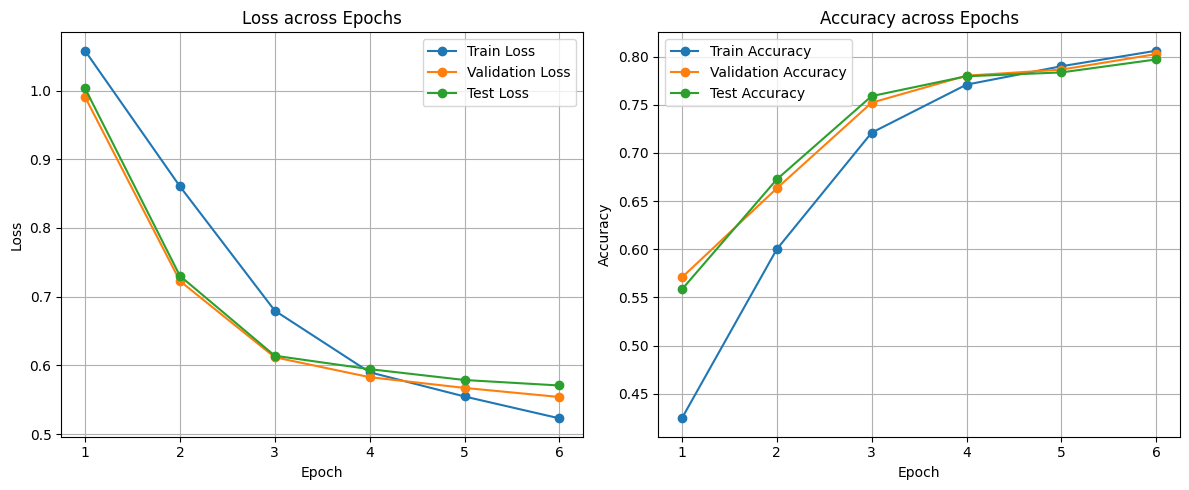

Fine-tuned embeddings saved to data/Aaron_Mikaela_subcellular_localization/fine_tuned_embeddings_Aaron_Mikaela_subcellular_localization.csv
best epoch number: 6


/home/macaulay/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/macaulay/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8136904761904762
Confusion Matrix: 
 [[308  51  17]
 [ 43 527  96]
 [ 14  92 532]]
Classification Report: 
                precision    recall  f1-score   support

Cell membrane       0.84      0.82      0.83       376
    Cytoplasm       0.79      0.79      0.79       666
      Nucleus       0.82      0.83      0.83       638

     accuracy                           0.81      1680
    macro avg       0.82      0.81      0.82      1680
 weighted avg       0.81      0.81      0.81      1680



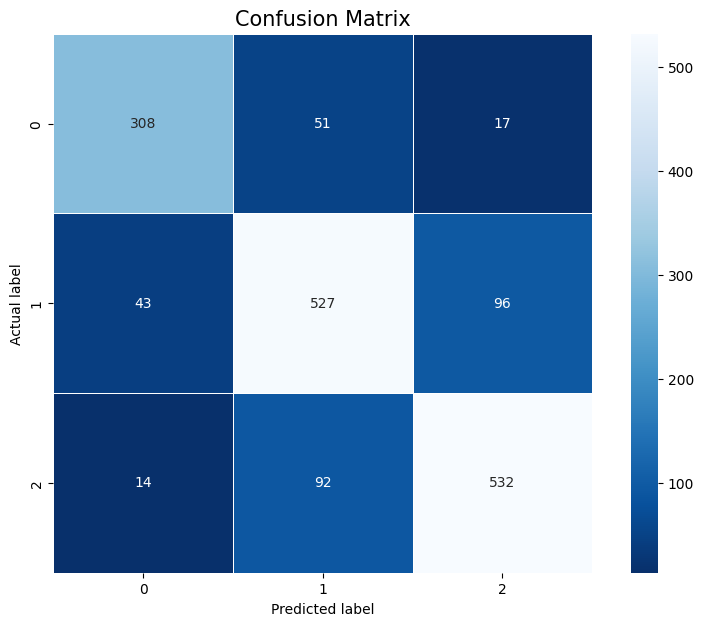

/home/macaulay/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/macaulay/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


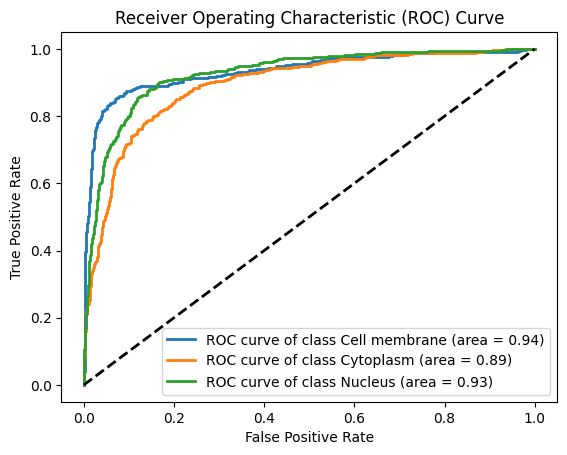

Attaching SeuratObject
******************************************

*                                        *

*          Welcome to WebGestaltR !      *

*                                        *

******************************************

Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Warning messages:
1: In eval(predvars, data, env) : NaNs produced
2: In hvf.info$variance.expected[not.const] <- 10^fit$fitted :
  number of items to replace is not a multiple of replacement length
Centering and scaling data matrix
  |======================================================================| 100%
To use Python UMAP via reticulate, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8401
Number of edges: 253567

Running Louvain algorithm...


**************************************************|


Maximum modularity in 10 random starts: 0.8681
Number of communities: 13
Elapsed time: 0 seconds
null device 
          1 
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
End weighted set cover...
Generate the final report...
Results can be found in the data/Aaron_Mikaela_subcellular_localization/enrichment_analysis/GeneLLM_all/Project_data_Aaron_Mikaela_subcellular_localization_enrichment_analysis_Reactome_cluster0!
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
End weighted set cover...
Generate the final report...
Results can be found in the data/Aaron_Mikaela

Warning message:
In oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum,  :
  No significant gene set is identified based on FDR 0.05!


null device 
          1 


In [3]:
#########################################----------Edit only this part---- Filepath & tasktype ----------------######################################################################

input_data_path = 'data/cellular_locations.csv'
task_type = "classification"
task_name = "Aaron_Mikaela_subcellular_localization"

#########################################----------Run----------------######################################################################

analyze(input_data_path, task_type, task_name)

## MSIGDB PATHWAYS ANNOTATION

Number of level2 labels: 292


Gene name                                            Summary  \
0               DNAH8  The protein encoded by this gene is a heavy ch...   
1               ITGB3  The ITGB3 protein product is the integrin beta...   
2               GATA4  This gene encodes a member of the GATA family ...   
3              ACSBG1  Filaggrin is a structural protein that is cruc...   
4             CYP4A11  Predicted to enable zinc ion transmembrane tra...   
...               ...                                                ...   
1393            TNNI1  Enables ribosomal large subunit binding activi...   
1394             CCL2  This gene is one of several cytokine genes clu...   
1395  TNFSF12-TNFSF13  SLC43A1 belongs to the system L family of plas...   
1396            CALM1  This gene encodes one of three calmodulin prot...   
1397           RALBP1  RALBP1 plays a role in receptor-mediated endoc...   

                                           Interactions  \
0     Consists of at least two heavy chains and a nu...   
1     Heterodimer of an alpha and a beta subunit.Bet...   
2     Interacts with ZNF260 (By similarity).Interact...   
3                                            Homodimer.   
4     Homodimer; dityrosine-linked.Homodimerization ...   
...                                                 ...   
1393  Monomer (PubMed:31226201).Interacts with POLRM...   
1394                                                NaN   
1395                                                NaN   
1396                                                NaN   
1397                                                NaN   

                                               StrLabel  \
0                               [BIOCARTA_LIS1_PATHWAY]   
1     [BIOCARTA_EDG1_PATHWAY, BIOCARTA_UCALPAIN_PATH...   
2         [BIOCARTA_ALK_PATHWAY, BIOCARTA_NFAT_PATHWAY]   
3                             [BIOCARTA_CHREBP_PATHWAY]   
4                          [BIOCARTA_NUCLEARRS_PATHWAY]   
...                                                 ...   
1393                             [BIOCARTA_NO1_PATHWAY]   
1394  [BIOCARTA_CCR5_PATHWAY, BIOCARTA_LDL_PATHWAY, ...   
1395                           [BIOCARTA_TALL1_PATHWAY]   
1396  [BIOCARTA_AT1R_PATHWAY, BIOCARTA_BCR_PATHWAY, ...   
1397      [BIOCARTA_RAC1_PATHWAY, BIOCARTA_RAS_PATHWAY]   

                                                  Label  
0     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...  
3     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                 ...  
1393  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1394  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1395  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1396  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1397  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[1398 rows x 5 columns]

Shape of tokens_df before gene2vec:(1398, 6)
Adding Gene2Vec data ...
Shape of tokens_df after gene2vec:(1387, 7)
Data saved to data/val_test_split_level2.json
model :microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract, gene2vec: False
Shape of tokens_df before gene2vec:(1398, 6)
Shape of tokens_df after gene2vec:(1398, 6)

#############################
Currently running {task_name}.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 30
-------------------------------
Training ...
Validation ...
Testing ...
	ET: 78.91 Seconds
Train Loss: 0.0372, Accuracy: 0.0, F1: 0.0421, Precision: 0.0113, Recall: 0.3105
Val Loss: 0.0234, Accuracy: 0.0, F1: 0.1029, Precision: 0.0108, Recall: 0.0641
Test Loss: 0.0237, Accuracy: 0.0, F1: 0.1157, Precision: 0.0211, Recall: 0.0791
Epoch 2 of 30
-------------------------------
Training ...
Validation ...
Testing ...
	ET: 79.3 Seconds
Train Loss: 0.0159, Accuracy: 0.0, F1: 0.1481, Precision: 0.0153, Recall: 0.0274
Val Loss: 0.0097, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Test Loss: 0.0104, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Epoch 3 of 30
-------------------------------
Training ...
Validation ...
Testing ...
	ET: 79.01 Seconds
Train Loss: 0.0082, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Val Loss: 0.0061, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Test Loss: 0.007, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Epoch 4 of 3

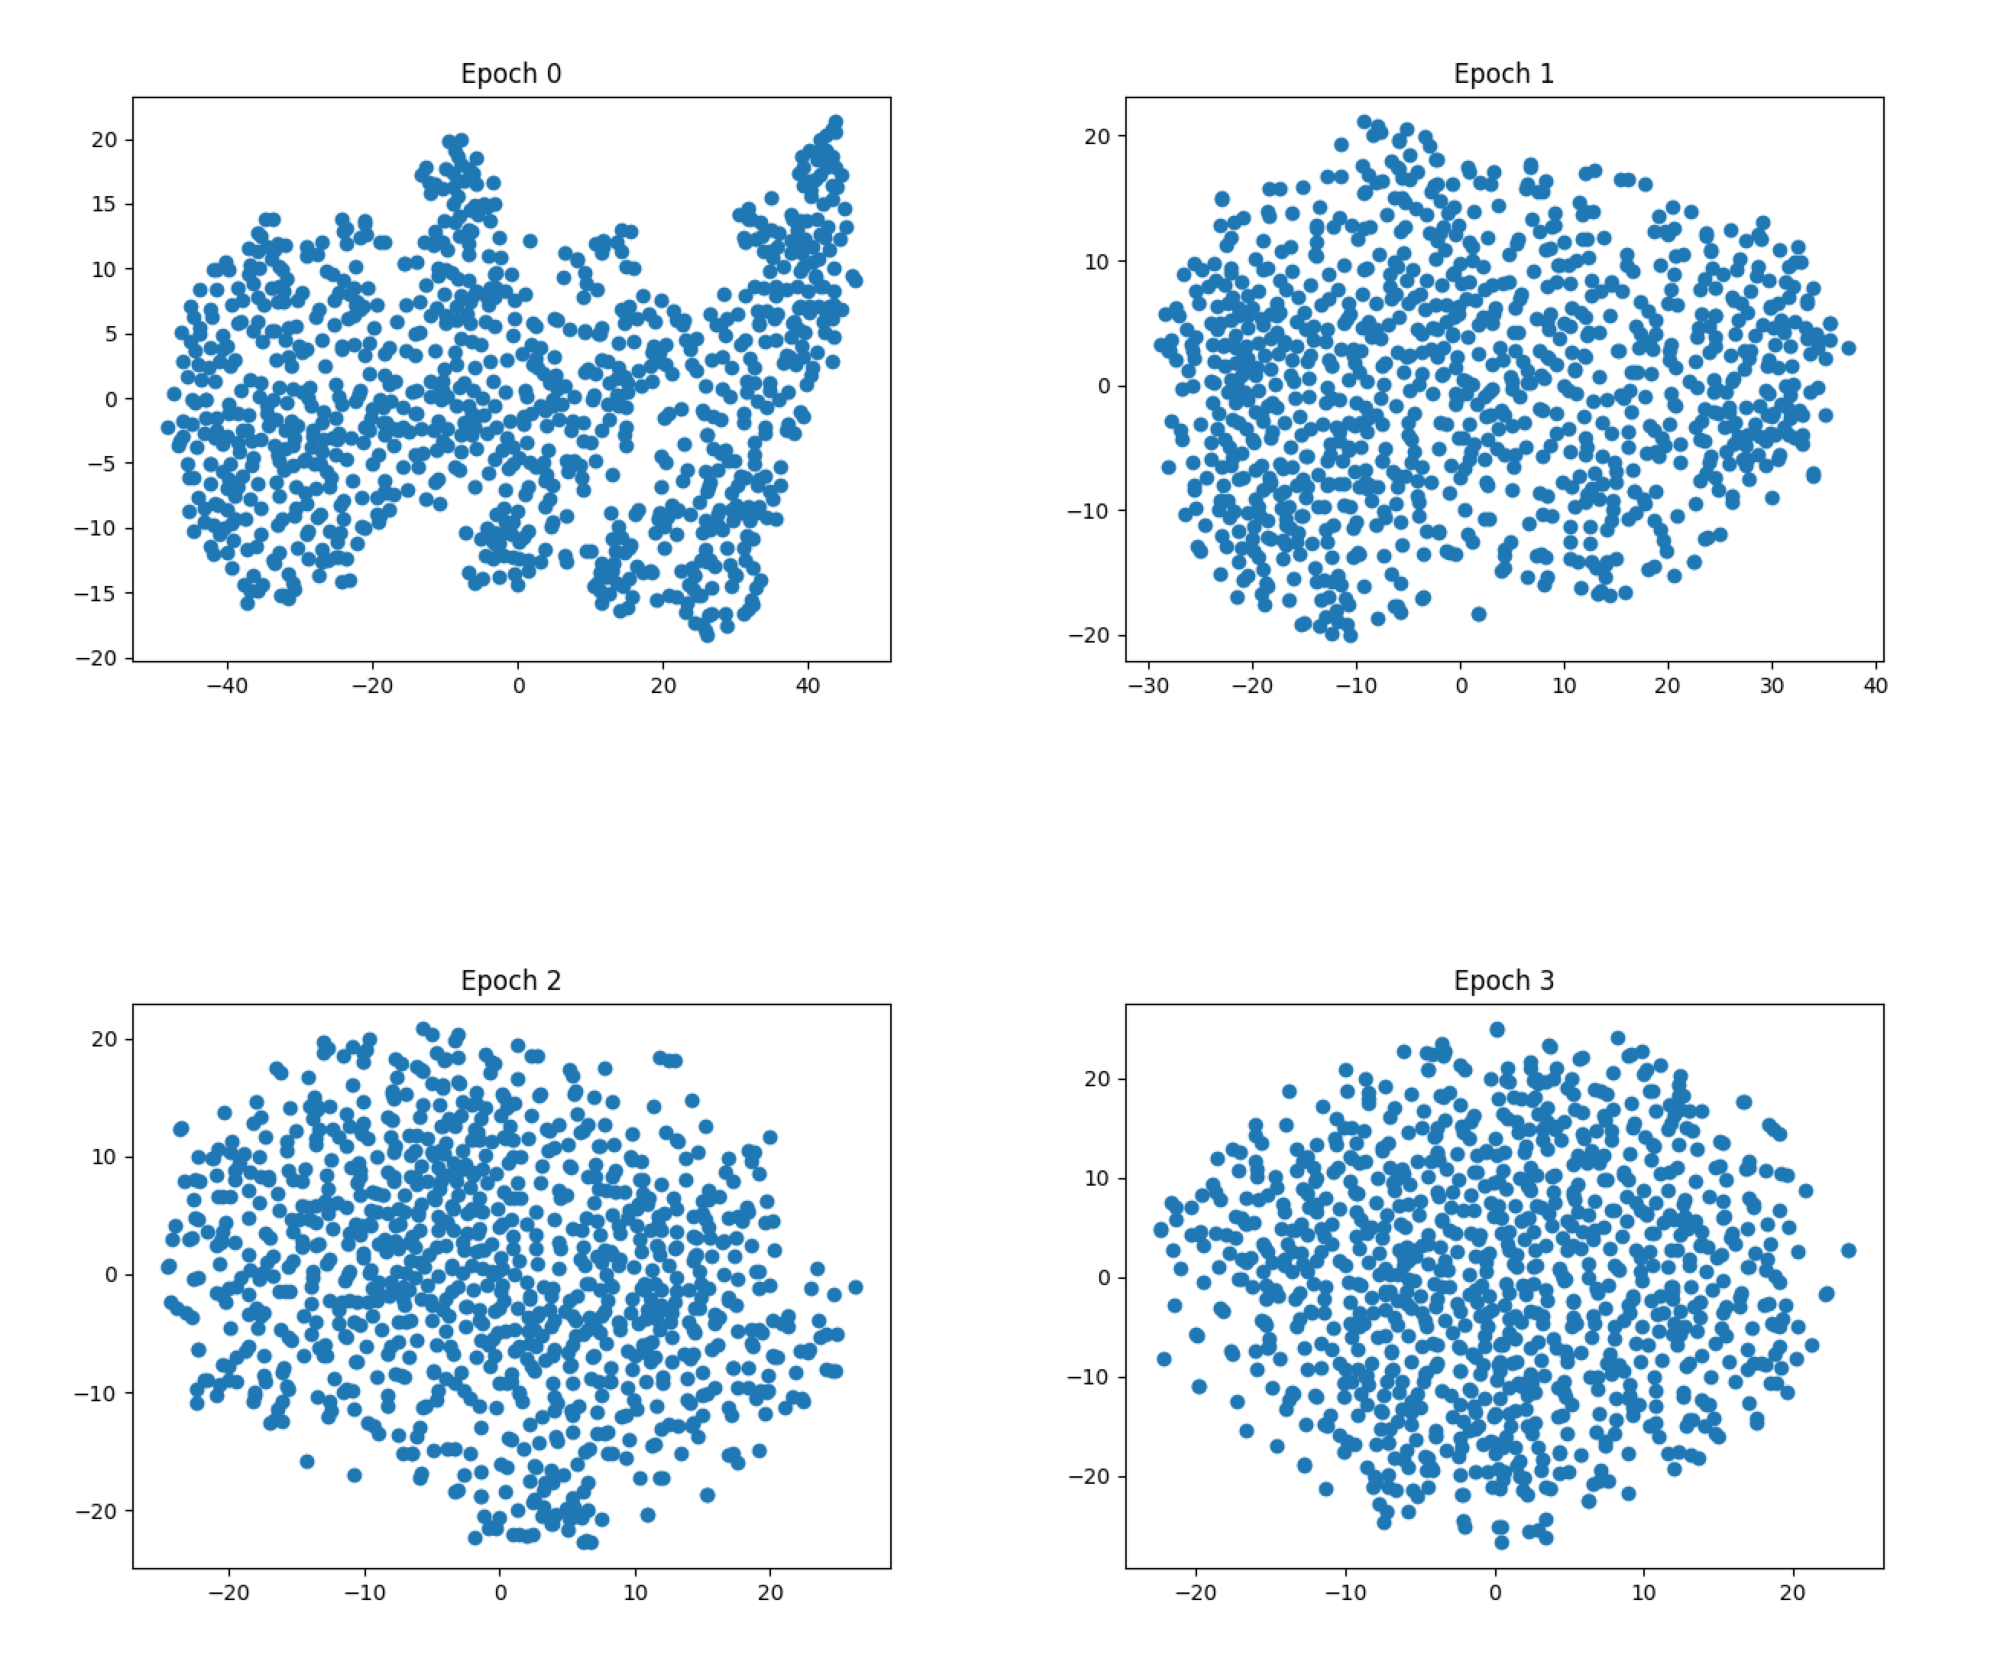

Attaching SeuratObject
******************************************

*                                        *

*          Welcome to WebGestaltR !      *

*                                        *

******************************************

Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Warning messages:
1: In eval(predvars, data, env) : NaNs produced
2: In hvf.info$variance.expected[not.const] <- 10^fit$fitted :
  number of items to replace is not a multiple of replacement length
Centering and scaling data matrix
  |======================================================================| 100%
To use Python UMAP via reticulate, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1523
Number of edges: 49782

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8788
Number of communities: 8
Elapsed time: 0 seconds
null device 
          1 
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Generate the final report...
Results can be found in the data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster0!
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Genera

Warning messages:
1: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster0' already exists
2: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster1' already exists
3: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster2' already exists
4: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster3' already exists
5: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster4' already exists
6: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster5' already exists
7: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster6' already exists
8: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster7' already exists


null device 
          1 


In [ ]:
#########################################----------Edit only this part---- Filepath & tasktype ----------------######################################################################

input_data_path = 'data/pathways.csv'
task_type = "multilabel"
task_name = "pathways"

#########################################----------Run----------------######################################################################

analyze(input_data_path, task_type, task_name)


## MSIGDB GO LEVEL

In [ ]:
#########################################----------Edit only this part---- Filepath & tasktype ----------------######################################################################

input_data_path = 'data/golevel.csv'
task_type = "multilabel"
task_name = "GO_NEW"
#########################################----------Run----------------######################################################################

analyze(input_data_path, task_type, task_name)


/tmp/ipykernel_2025887/4233155494.py:437: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,2

Number of GO_NEW labels: 15999


Gene name                                            Summary  \
0              FES  This gene encodes the human cellular counterpa...   
1           SLC7A7  The protein encoded by this gene is the light ...   
2            HSPA2  Enables disordered domain specific binding act...   
3           ZSCAN9  Enables sequence-specific double-stranded DNA ...   
4          SEPTIN3  This gene encodes a member of the sorting nexi...   
...            ...                                                ...   
14853  IQCJ-SCHIP1  C19orf25 (Chromosome 19 Open Reading Frame 25)...   
14854        BPY2C  This gene is located in the nonrecombining por...   
14855         DNER  The protein encoded by this gene is a cofactor...   
14856         SOX7  Predicted to enable Notch binding activity. In...   
14857       CXCL14  This gene encodes a member of the SOX (SRY-rel...   

                                            Interactions  \
0      Homooligomer.Interacts with BCR.Interacts (whe...   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4      Interacts with ATP6V1D; may play a role in cil...   
...                                                  ...   
14853                                                NaN   
14854  Interacts with MAP1S.Interacts with UBE3A (via...   
14855  Forms a 1:1 stoichiometric complex with pancre...   
14856  Interacts with AP1G1.Interacts with NOTCH1 (By...   
14857  Interacts with CTNNB1/beta-catenin; this inter...   

                                                StrLabel  \
0      [GOBP_CARDIAC_MUSCLE_CELL_PROLIFERATION, GOBP_...   
1      [GOBP_ALPHA_AMINO_ACID_METABOLIC_PROCESS, GOBP...   
2      [GOBP_CELLULAR_COMPONENT_DISASSEMBLY, GOBP_CEL...   
3      [GOMF_CIS_REGULATORY_REGION_SEQUENCE_SPECIFIC_...   
4      [GOBP_CELL_CYCLE, GOBP_CELL_CYCLE_PROCESS, GOB...   
...                                                  ...   
14853  [GOBP_CYTOSKELETON_ORGANIZATION, GOBP_HIPPO_SI...   
14854  [GOBP_DEVELOPMENTAL_PROCESS_INVOLVED_IN_REPROD...   
14855  [GOBP_CELL_JUNCTION_ASSEMBLY, GOBP_CELL_JUNCTI...   
14856  [GOBP_ANATOMICAL_STRUCTURE_FORMATION_INVOLVED_...   
14857  [GOBP_ANTIMICROBIAL_HUMORAL_IMMUNE_RESPONSE_ME...   

                                                   Label  
0      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
...                                                  ...  
14853  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
14854  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
14855  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
14856  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
14857  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  

[14858 rows x 5 columns]

Shape of tokens_df before gene2vec:(14858, 6)
Adding Gene2Vec data ...
Shape of tokens_df after gene2vec:(13430, 7)
Data saved to data/val_test_split_GO_NEW.json
model :microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract, gene2vec: False
Shape of tokens_df before gene2vec:(14858, 6)
Shape of tokens_df after gene2vec:(14858, 6)

#############################
Currently running {task_name}.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 30
-------------------------------
Training ...
Validation ...
Testing ...
	ET: 1898.87 Seconds
Train Loss: 0.021, Accuracy: 0.0, F1: 0.0096, Precision: 0.005, Recall: 0.1471
Val Loss: 0.004, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Test Loss: 0.004, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Epoch 2 of 30
-------------------------------
Training ...
Validation ...
Testing ...
	ET: 1594.6 Seconds
Train Loss: 0.0028, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Val Loss: 0.0023, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Test Loss: 0.0024, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Epoch 3 of 30
-------------------------------
Training ...
Validation ...
Testing ...
	ET: 1377.95 Seconds
Train Loss: 0.0021, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Val Loss: 0.0021, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Test Loss: 0.0022, Accuracy: 0.0, F1: nan, Precision: nan, Recall: 0.0
Epoch 4 of 30
----------------------

## SUPERVISED Gene Ontology

Number of level2 labels: 12


Gene name                                            Summary  \
0        MPEG1  This gene encodes a glycosyltransferase that p...   
1        CNGB3  Involved in cell migration. Located in recycli...   
2       POLR3E  The protein encoded by this gene localizes to ...   
3        INAVA  Predicted to enable DNA-directed 5'-3' RNA pol...   
4        ERAP2  The protein encoded by this gene belongs to th...   
...        ...                                                ...   
1518     OR1D5  This gene encodes a member of the bHLH family ...   
1519     DEFA6  Predicted to be involved in several processes ...   
1520     TCF23  Homeodomain proteins are sequence-specific tra...   
1521    OR12D1  This gene encodes an angiogenic factor that pr...   
1522     OR4D6  This gene encodes a protein that belongs to th...   

                                           Interactions      StrLabel  \
0                                                   NaN  [GO:0002376]   
1                                                   NaN  [GO:0050896]   
2                                                   NaN  [GO:0002376]   
3     Component of the RNA polymerase III (Pol III) ...  [GO:0002376]   
4                        Interacts with IGFN1 and FLNC.  [GO:0002376]   
...                                                 ...           ...   
1518  The sequence DAA00304.1 differs from that show...  [GO:0050896]   
1519         Binds itself as well as AMIGO1 and AMIGO3.  [GO:0002376]   
1520  The sequence BAB83665.1 differs from that show...  [GO:0032502]   
1521  Interacts with the secreted angiogenic factor ...  [GO:0050896]   
1522                              Interacts with PRDM8.  [GO:0050896]   

                                     Label  
0     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  
2     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
3     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
4     [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
...                                    ...  
1518  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  
1519  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  
1520  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]  
1521  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  
1522  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  

[1523 rows x 5 columns]

Shape of tokens_df before gene2vec:(1523, 6)
Adding Gene2Vec data ...
Shape of tokens_df after gene2vec:(1184, 7)
Data saved to data/val_test_split_level2.json
model :microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract, gene2vec: False
Shape of tokens_df before gene2vec:(1523, 6)
Shape of tokens_df after gene2vec:(1523, 6)

#############################
Currently running {task_name}.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 30
-------------------------------
Training ...
Validation ...
Testing ...
	ET: 89.2 Seconds
Train Loss: 0.3592, Accuracy: 0.2213, F1: 0.9029, Precision: 0.4969, Recall: 0.269
Val Loss: 0.2671, Accuracy: 0.2525, F1: 0.9758, Precision: 0.2792, Recall: 0.2624
Test Loss: 0.2725, Accuracy: 0.191, F1: 0.9649, Precision: 0.2262, Recall: 0.2022
best_epoch_num
Epoch 2 of 30
-------------------------------
Training ...
Validation ...
Testing ...
	ET: 90.29 Seconds
Train Loss: 0.2055, Accuracy: 0.3281, F1: 0.9991, Precision: 0.7611, Recall: 0.3285
Val Loss: 0.2179, Accuracy: 0.3168, F1: 0.9671, Precision: 0.6574, Recall: 0.3342
Test Loss: 0.2216, Accuracy: 0.2978, F1: 0.9879, Precision: 0.5238, Recall: 0.3034
best_epoch_num
Epoch 3 of 30
-------------------------------
Training ...
Validation ...
Testing ...
	ET: 90.18 Seconds
Train Loss: 0.1694, Accuracy: 0.5101, F1: 0.9944, Precision: 0.8733, Recall: 0.5144
Val Loss: 0.177, Accuracy: 0.5347, F1: 0.9744, Precision: 0.854, Recall: 0.5

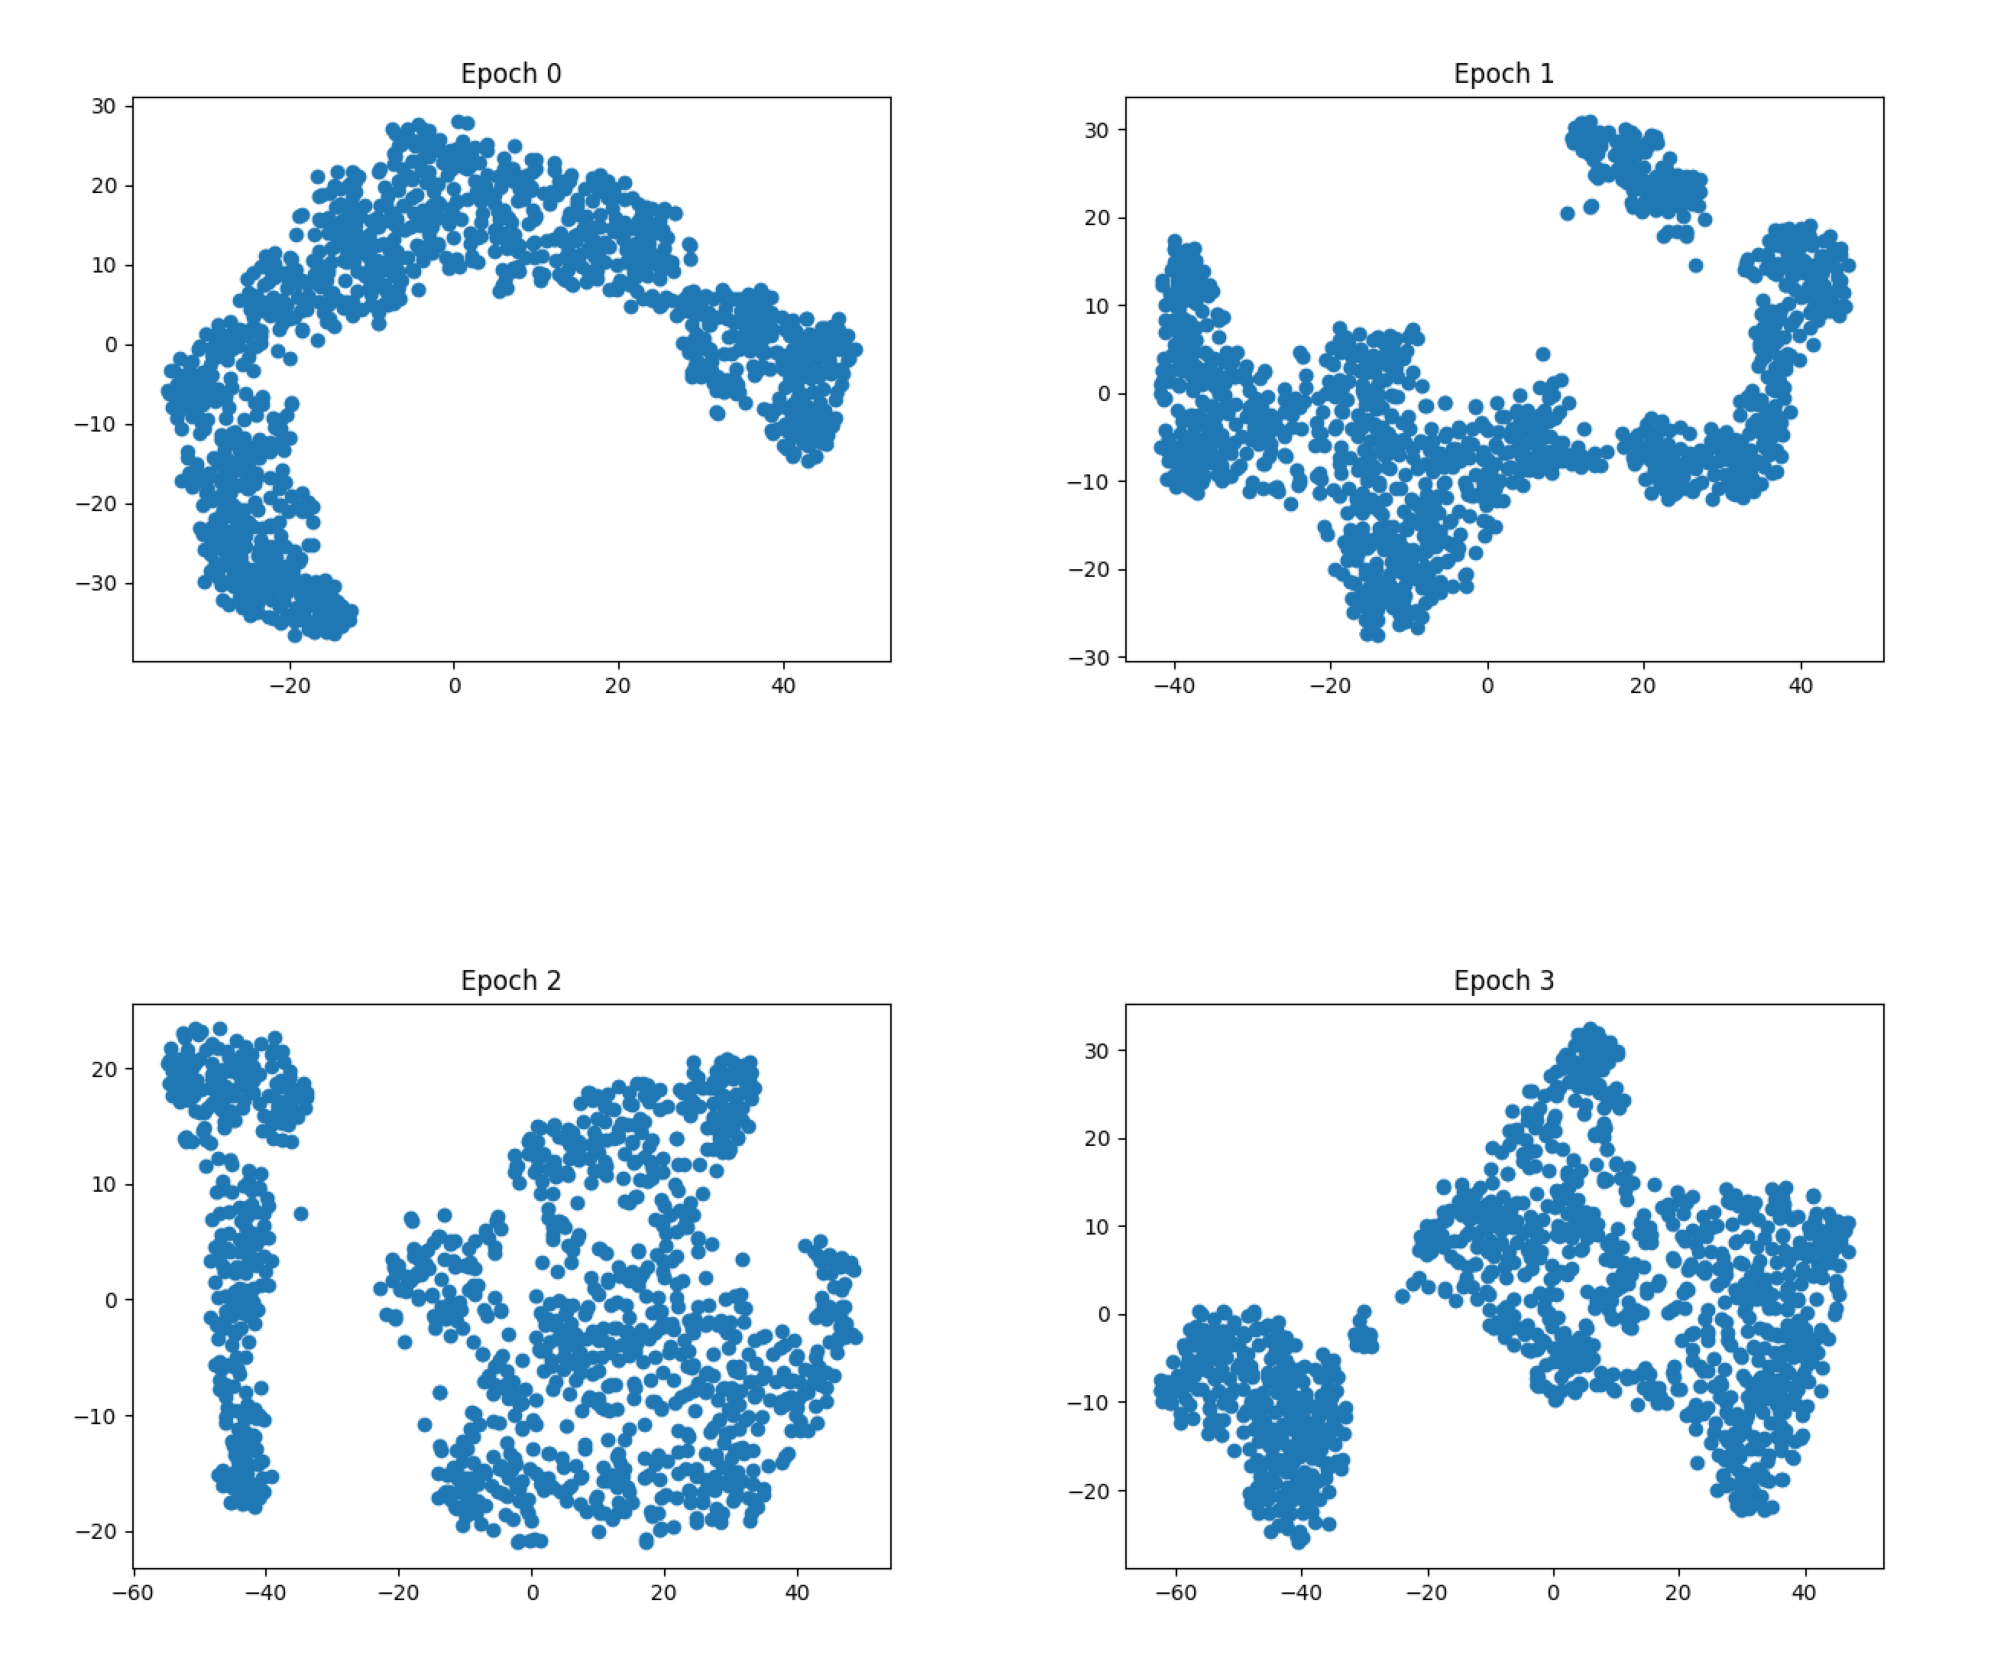

Attaching SeuratObject
******************************************

*                                        *

*          Welcome to WebGestaltR !      *

*                                        *

******************************************

Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Warning messages:
1: In eval(predvars, data, env) : NaNs produced
2: In hvf.info$variance.expected[not.const] <- 10^fit$fitted :
  number of items to replace is not a multiple of replacement length
Centering and scaling data matrix
  |======================================================================| 100%
To use Python UMAP via reticulate, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1523
Number of edges: 49782

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8788
Number of communities: 8
Elapsed time: 0 seconds
null device 
          1 
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Generate the final report...
Results can be found in the data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster0!
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Genera

Warning messages:
1: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster0' already exists
2: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster1' already exists
3: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster2' already exists
4: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster3' already exists
5: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster4' already exists
6: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster5' already exists
7: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster6' already exists
8: In dir.create(projectDir) :
  'data/level2/GeneLLM_all/Project_data_level2_Reactome_cluster7' already exists


null device 
          1 


In [ ]:
#########################################----------Edit only this part---- Filepath & tasktype ----------------######################################################################

input_data_path = 'data/level2.csv'
task_type = "multilabel"
task_name = "level2"
#########################################----------Run----------------######################################################################

analyze(input_data_path, task_type, task_name)


# Conservation 

Number of Conservation labels: 1


Gene name                                            Summary  \
0              FES  This gene encodes the human cellular counterpa...   
1           SLC7A7  The protein encoded by this gene is the light ...   
2            HSPA2  Enables disordered domain specific binding act...   
3           ZSCAN9  Enables sequence-specific double-stranded DNA ...   
4          SEPTIN3  This gene encodes a member of the sorting nexi...   
...            ...                                                ...   
14512     C19orf25  This gene encodes a T-box family member. The T...   
14513  IQCJ-SCHIP1  C19orf25 (Chromosome 19 Open Reading Frame 25)...   
14514        BPY2C  This gene is located in the nonrecombining por...   
14515         DNER  The protein encoded by this gene is a cofactor...   
14516       CXCL14  This gene encodes a member of the SOX (SRY-rel...   

                                            Interactions     Label  
0      Homooligomer.Interacts with BCR.Interacts (whe...  0.640952  
1                                                    NaN  0.418753  
2                                                    NaN  0.424108  
3                                                    NaN  0.090192  
4      Interacts with ATP6V1D; may play a role in cil...  0.703949  
...                                                  ...       ...  
14512  The sequence AAD21787.1 differs from that show...  0.160615  
14513                                                NaN  0.668076  
14514  Interacts with MAP1S.Interacts with UBE3A (via...  0.066946  
14515  Forms a 1:1 stoichiometric complex with pancre...  0.662750  
14516  Interacts with CTNNB1/beta-catenin; this inter...  0.606774  

[14517 rows x 4 columns]

Shape of tokens_df before gene2vec:(14517, 6)
Adding Gene2Vec data ...
Shape of tokens_df after gene2vec:(13041, 7)
Data saved to data/val_test_split_Conservation.json
model :microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract, gene2vec: False
Shape of tokens_df before gene2vec:(14517, 6)
Shape of tokens_df after gene2vec:(14517, 6)

###############################
Currently running Conservation.
###############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 5
-------------------------------
Training ...


100%|██████████| 518/518 [12:01<00:00,  1.39s/it]


Validation ...


100%|██████████| 111/111 [00:50<00:00,  2.20it/s]


Testing ...


100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


	ET: 833.82 Seconds
	Train Loss: 0.0351, corrcoef: 0.4122
	Val Loss: 0.0322, corrcoef: 0.4715
	Test Loss: 0.0314, corrcoef: 0.4629
Epoch 2 of 5
-------------------------------
Training ...


100%|██████████| 518/518 [12:01<00:00,  1.39s/it]


Validation ...


100%|██████████| 111/111 [00:50<00:00,  2.20it/s]


Testing ...


100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


	ET: 833.97 Seconds
	Train Loss: 0.0294, corrcoef: 0.5317
	Val Loss: 0.0307, corrcoef: 0.4906
	Test Loss: 0.0302, corrcoef: 0.4862
Epoch 3 of 5
-------------------------------
Training ...


100%|██████████| 518/518 [12:01<00:00,  1.39s/it]


Validation ...


100%|██████████| 111/111 [00:50<00:00,  2.20it/s]


Testing ...


100%|██████████| 98/98 [00:44<00:00,  2.19it/s]


	ET: 834.12 Seconds
	Train Loss: 0.0257, corrcoef: 0.6018
	Val Loss: 0.0294, corrcoef: 0.4933
	Test Loss: 0.0289, corrcoef: 0.4875
Epoch 4 of 5
-------------------------------
Training ...


100%|██████████| 518/518 [12:01<00:00,  1.39s/it]


Validation ...


100%|██████████| 111/111 [00:50<00:00,  2.20it/s]


Testing ...


100%|██████████| 98/98 [00:45<00:00,  2.18it/s]


	ET: 832.61 Seconds
	Train Loss: 0.021, corrcoef: 0.6908
	Val Loss: 0.0308, corrcoef: 0.4759
	Test Loss: 0.0298, corrcoef: 0.4782
Epoch 5 of 5
-------------------------------
Training ...


100%|██████████| 518/518 [11:58<00:00,  1.39s/it]


Validation ...


100%|██████████| 111/111 [00:50<00:00,  2.21it/s]


Testing ...


100%|██████████| 98/98 [00:44<00:00,  2.20it/s]


	ET: 828.0 Seconds
	Train Loss: 0.0169, corrcoef: 0.7638
	Val Loss: 0.0326, corrcoef: 0.4803
	Test Loss: 0.0318, corrcoef: 0.4796
Fine-tuned embeddings saved to data/fine_tuned_embeddings_Conservation2.csv
best epoch number: 2


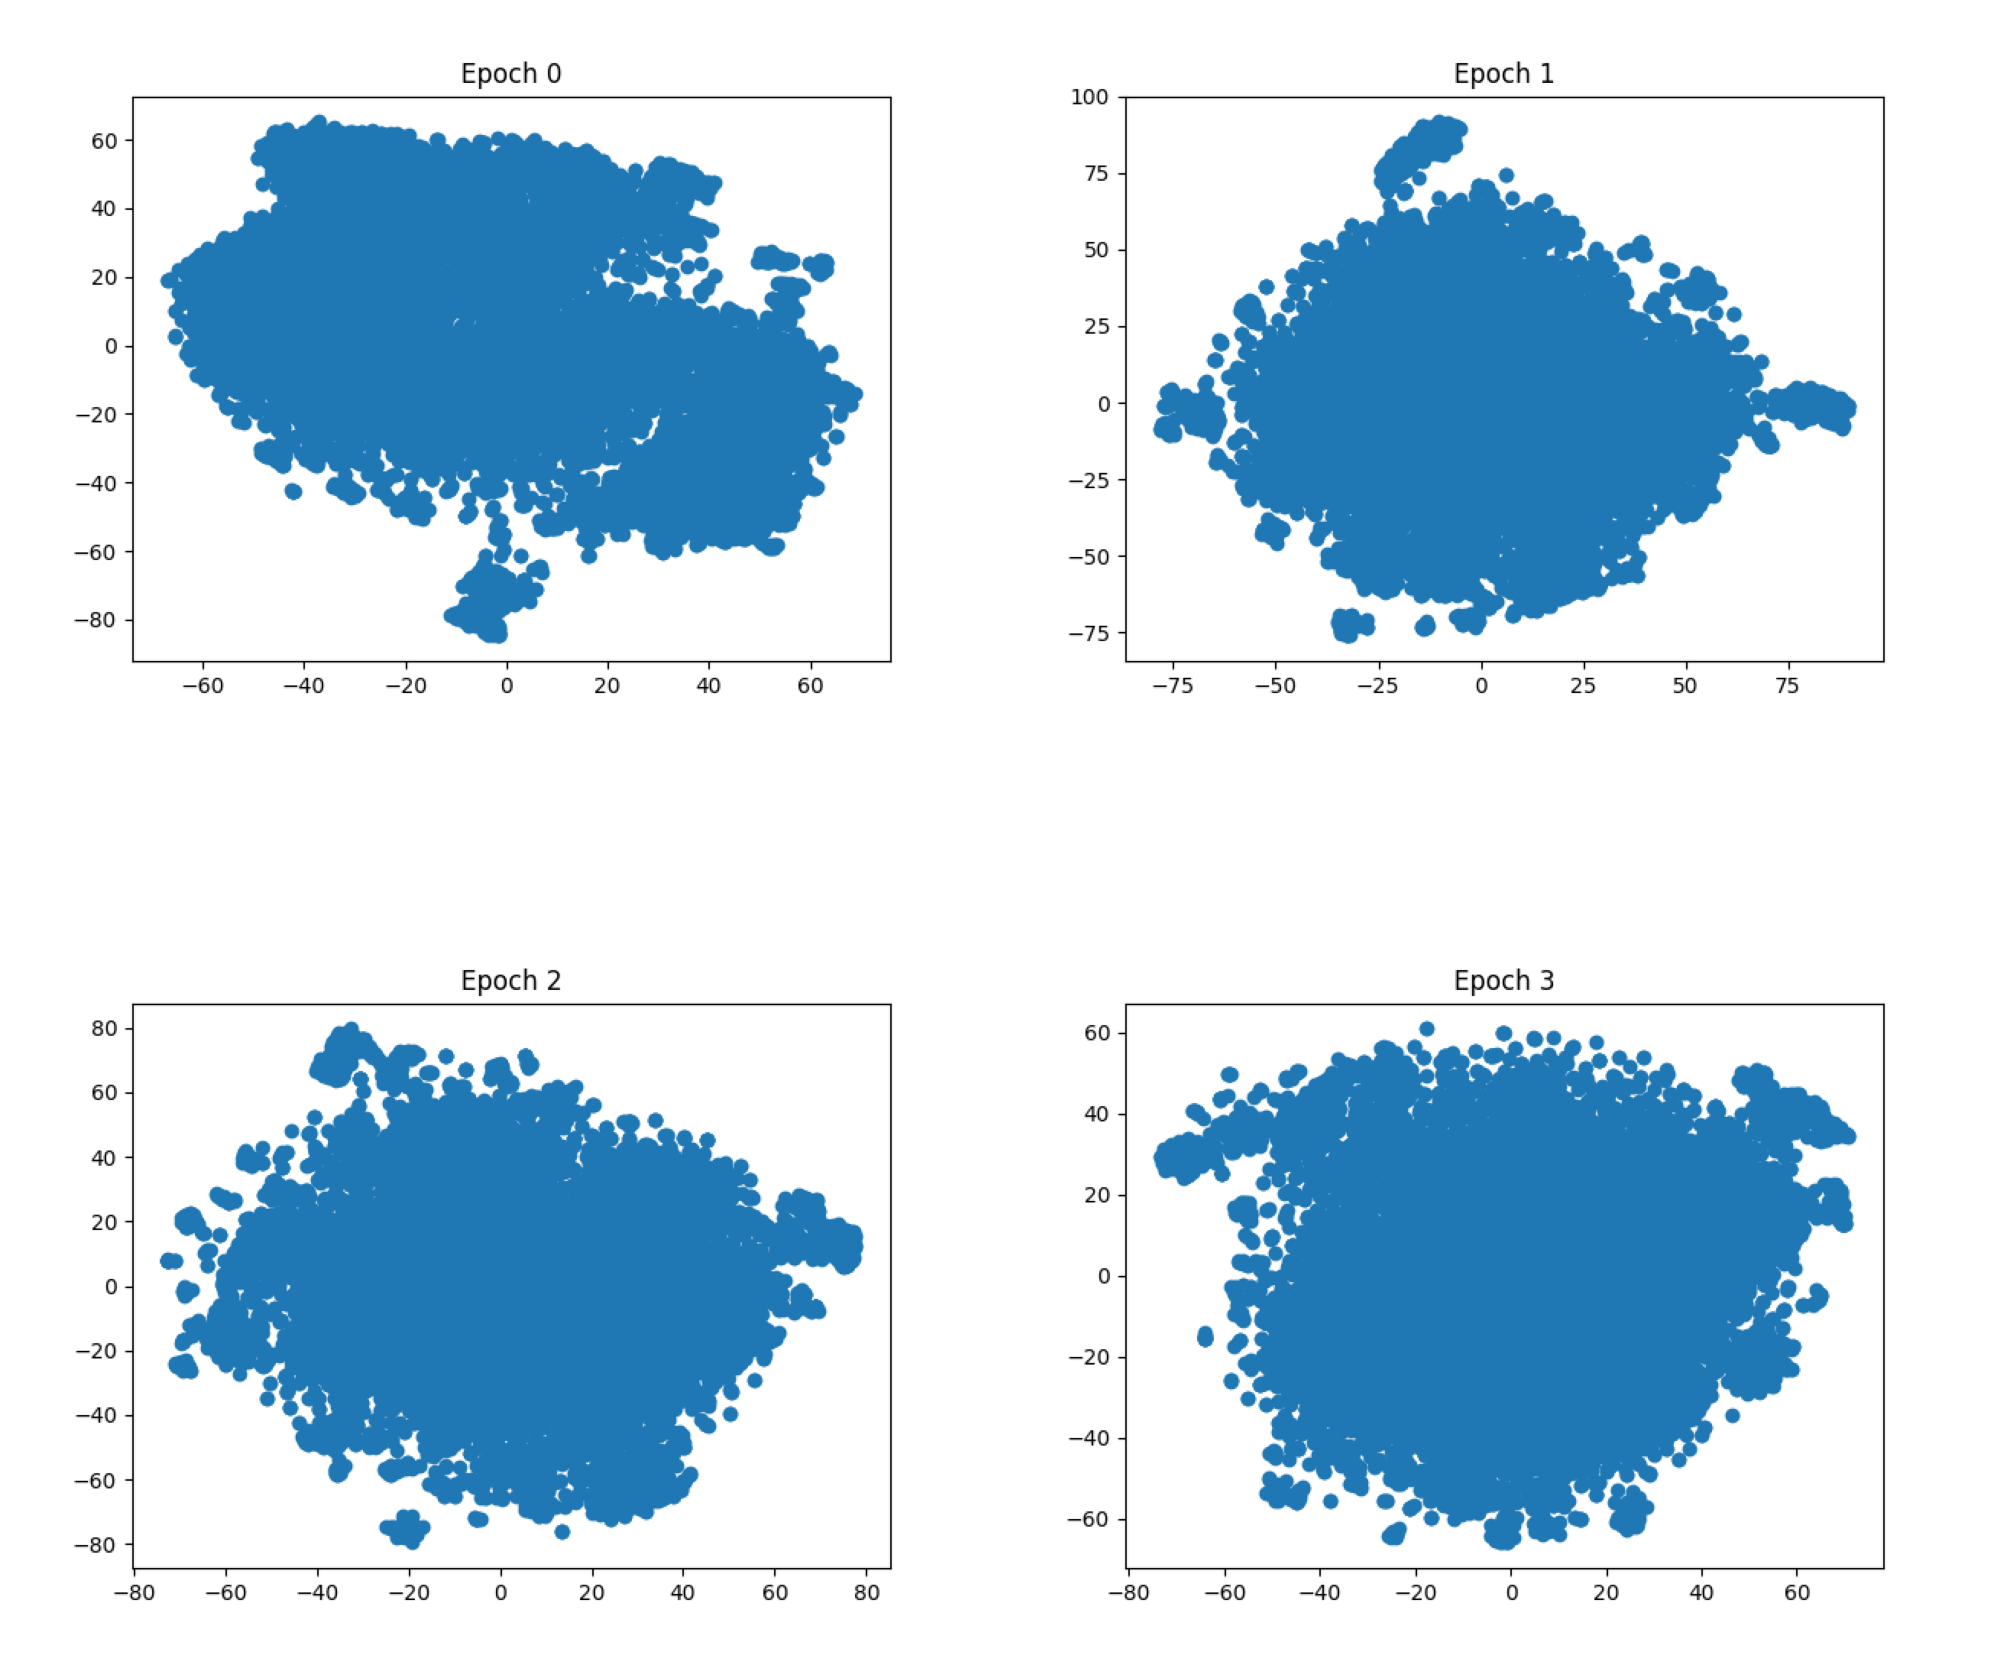

Attaching SeuratObject
******************************************

*                                        *

*          Welcome to WebGestaltR !      *

*                                        *

******************************************

Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Warning messages:
1: In eval(predvars, data, env) : NaNs produced
2: In hvf.info$variance.expected[not.const] <- 10^fit$fitted :
  number of items to replace is not a multiple of replacement length
Centering and scaling data matrix
  |======================================================================| 100%
To use Python UMAP via reticulate, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14517
Number of edges: 392931

Running Louvain algorithm...


0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


Maximum modularity in 10 random starts: 0.7973
Number of communities: 15
Elapsed time: 1 seconds
null device 
          1 
ERROR: The output directory GeneLLM_all does not exist. please change another directory or create the directory.ERROR: The output directory GeneLLM_all does not exist. please change another directory or create the directory.ERROR: The output directory GeneLLM_all does not exist. please change another directory or create the directory.ERROR: The output directory GeneLLM_all does not exist. please change another directory or create the directory.ERROR: The output directory GeneLLM_all does not exist. please change another directory or create the directory.ERROR: The output directory GeneLLM_all does not exist. please change another directory or create the directory.ERROR: The output directory GeneLLM_all does not exist. please change another directory or create the directory.ERROR: The output directory GeneLLM_all does not exist. please change another directory or cr

Error in names(new_names) <- levels(final_seu_all) : 
  'names' attribute [15] must be the same length as the vector [14]
Execution halted


In [ ]:
#########################################----------Edit only this part---- Filepath & tasktype ----------------######################################################################

input_data_path = 'data/phastcons.csv'
task_type = "regression"
task_name = "conservations"

#########################################----------Run----------------######################################################################

analyze(input_data_path, task_type, task_name)


# Subcellular Locations

In [ ]:
#########################################----------Edit only this part---- Filepath & tasktype ----------------######################################################################

input_data_path = 'data/subcellular_location.csv'
task_type = "classification"
task_name = "subcellular_location"
#########################################----------Run----------------######################################################################

analyze(input_data_path, task_type, task_name)


# Solubility

Number of solubility labels: 2


Gene name                                            Summary  \
0        ERAP2  The protein encoded by this gene belongs to th...   
1     ADAMTSL5  The product of the MND1 gene associates with H...   
2      TBC1D30  Predicted to act upstream of or within with a ...   
3       KCNK18  Enables GTPase activator activity and small GT...   
4         NDNF  Human platelet glycoprotein V (GP5) is a part ...   
...        ...                                                ...   
1426      RPS9  Ribosomes the organelles that catalyze protein...   
1427     NBPF1  Olfactory receptors interact with odorant mole...   
1428  SLC22A16  Predicted to be involved in protein transport ...   
1429      FBN3  Enables N-(long-chain-acyl)ethanolamine deacyl...   
1430      BDH2  This gene encodes an alpha integrin. Integrins...   

                                           Interactions Solubility  Label  
0                        Interacts with IGFN1 and FLNC.   Membrane      0  
1     Heterodimer with PSMC3IP/HOP2.MND1-PSMC3IP int...    Soluble      1  
2     The sequence AAD34068.1 differs from that show...   Membrane      0  
3     The sequence BAA76828.1 differs from that show...   Membrane      0  
4                                                   NaN    Soluble      1  
...                                                 ...        ...    ...  
1426                                                NaN    Soluble      1  
1427                                                NaN    Soluble      1  
1428  The sequence AAQ89038.1 differs from that show...   Membrane      0  
1429  Heterodimer of an alpha and a beta subunit  pr...    Soluble      1  
1430  Heterodimer of an alpha and a beta subunit.Alp...    Soluble      1  

[1431 rows x 5 columns]

Shape of tokens_df before gene2vec:(1431, 6)
Shape of tokens_df after gene2vec:(1431, 6)
Data saved to data/solubility/val_test_split_solubility.json
model :microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract, gene2vec: False
Shape of tokens_df before gene2vec:(1431, 6)
Shape of tokens_df after gene2vec:(1431, 6)

#############################
Currently running solubility.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 15
-------------------------------
Training ...
torch.Size([972, 1024])
Validation ...
Testing ...
	ET: 79.52 Seconds
Train Loss: 0.6948, Accuracy: 0.5144, F1: 0.5108, Precision: 0.5111, Recall: 0.5144
Val Loss: 0.6918, Accuracy: 0.5246, F1: 0.4493, Precision: 0.5935, Recall: 0.5246
Test Loss: 0.6964, Accuracy: 0.4837, F1: 0.3935, Precision: 0.4911, Recall: 0.4837
best_epoch_num: 1
Epoch 2 of 15
-------------------------------
Training ...
torch.Size([972, 1024])
Validation ...
Testing ...
	ET: 79.77 Seconds
Train Loss: 0.6875, Accuracy: 0.5473, F1: 0.5243, Precision: 0.5435, Recall: 0.5473
Val Loss: 0.6849, Accuracy: 0.5656, F1: 0.5098, Precision: 0.653, Recall: 0.5656
Test Loss: 0.688, Accuracy: 0.5395, F1: 0.4757, Precision: 0.6034, Recall: 0.5395
best_epoch_num: 2
Epoch 3 of 15
-------------------------------
Training ...
torch.Size([972, 1024])
Validation ...
Testing ...
	ET: 79.66 Seconds
Train Loss: 0.6738, Accuracy: 0.6049, F1: 0.5872, Precision: 0.6113, Recall: 0.60

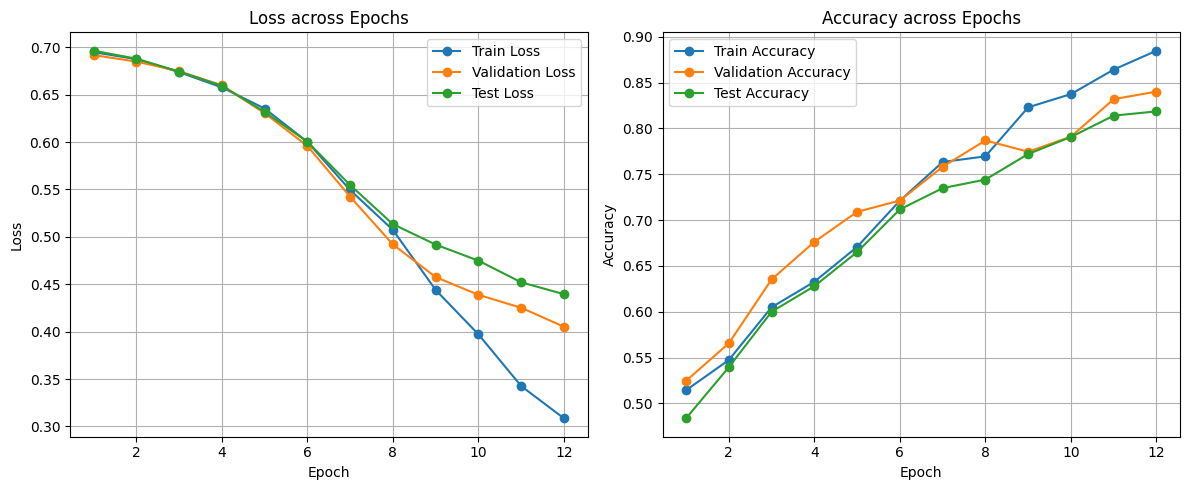

Fine-tuned embeddings saved to data/solubility/fine_tuned_embeddings_solubility.csv
best epoch number: 12


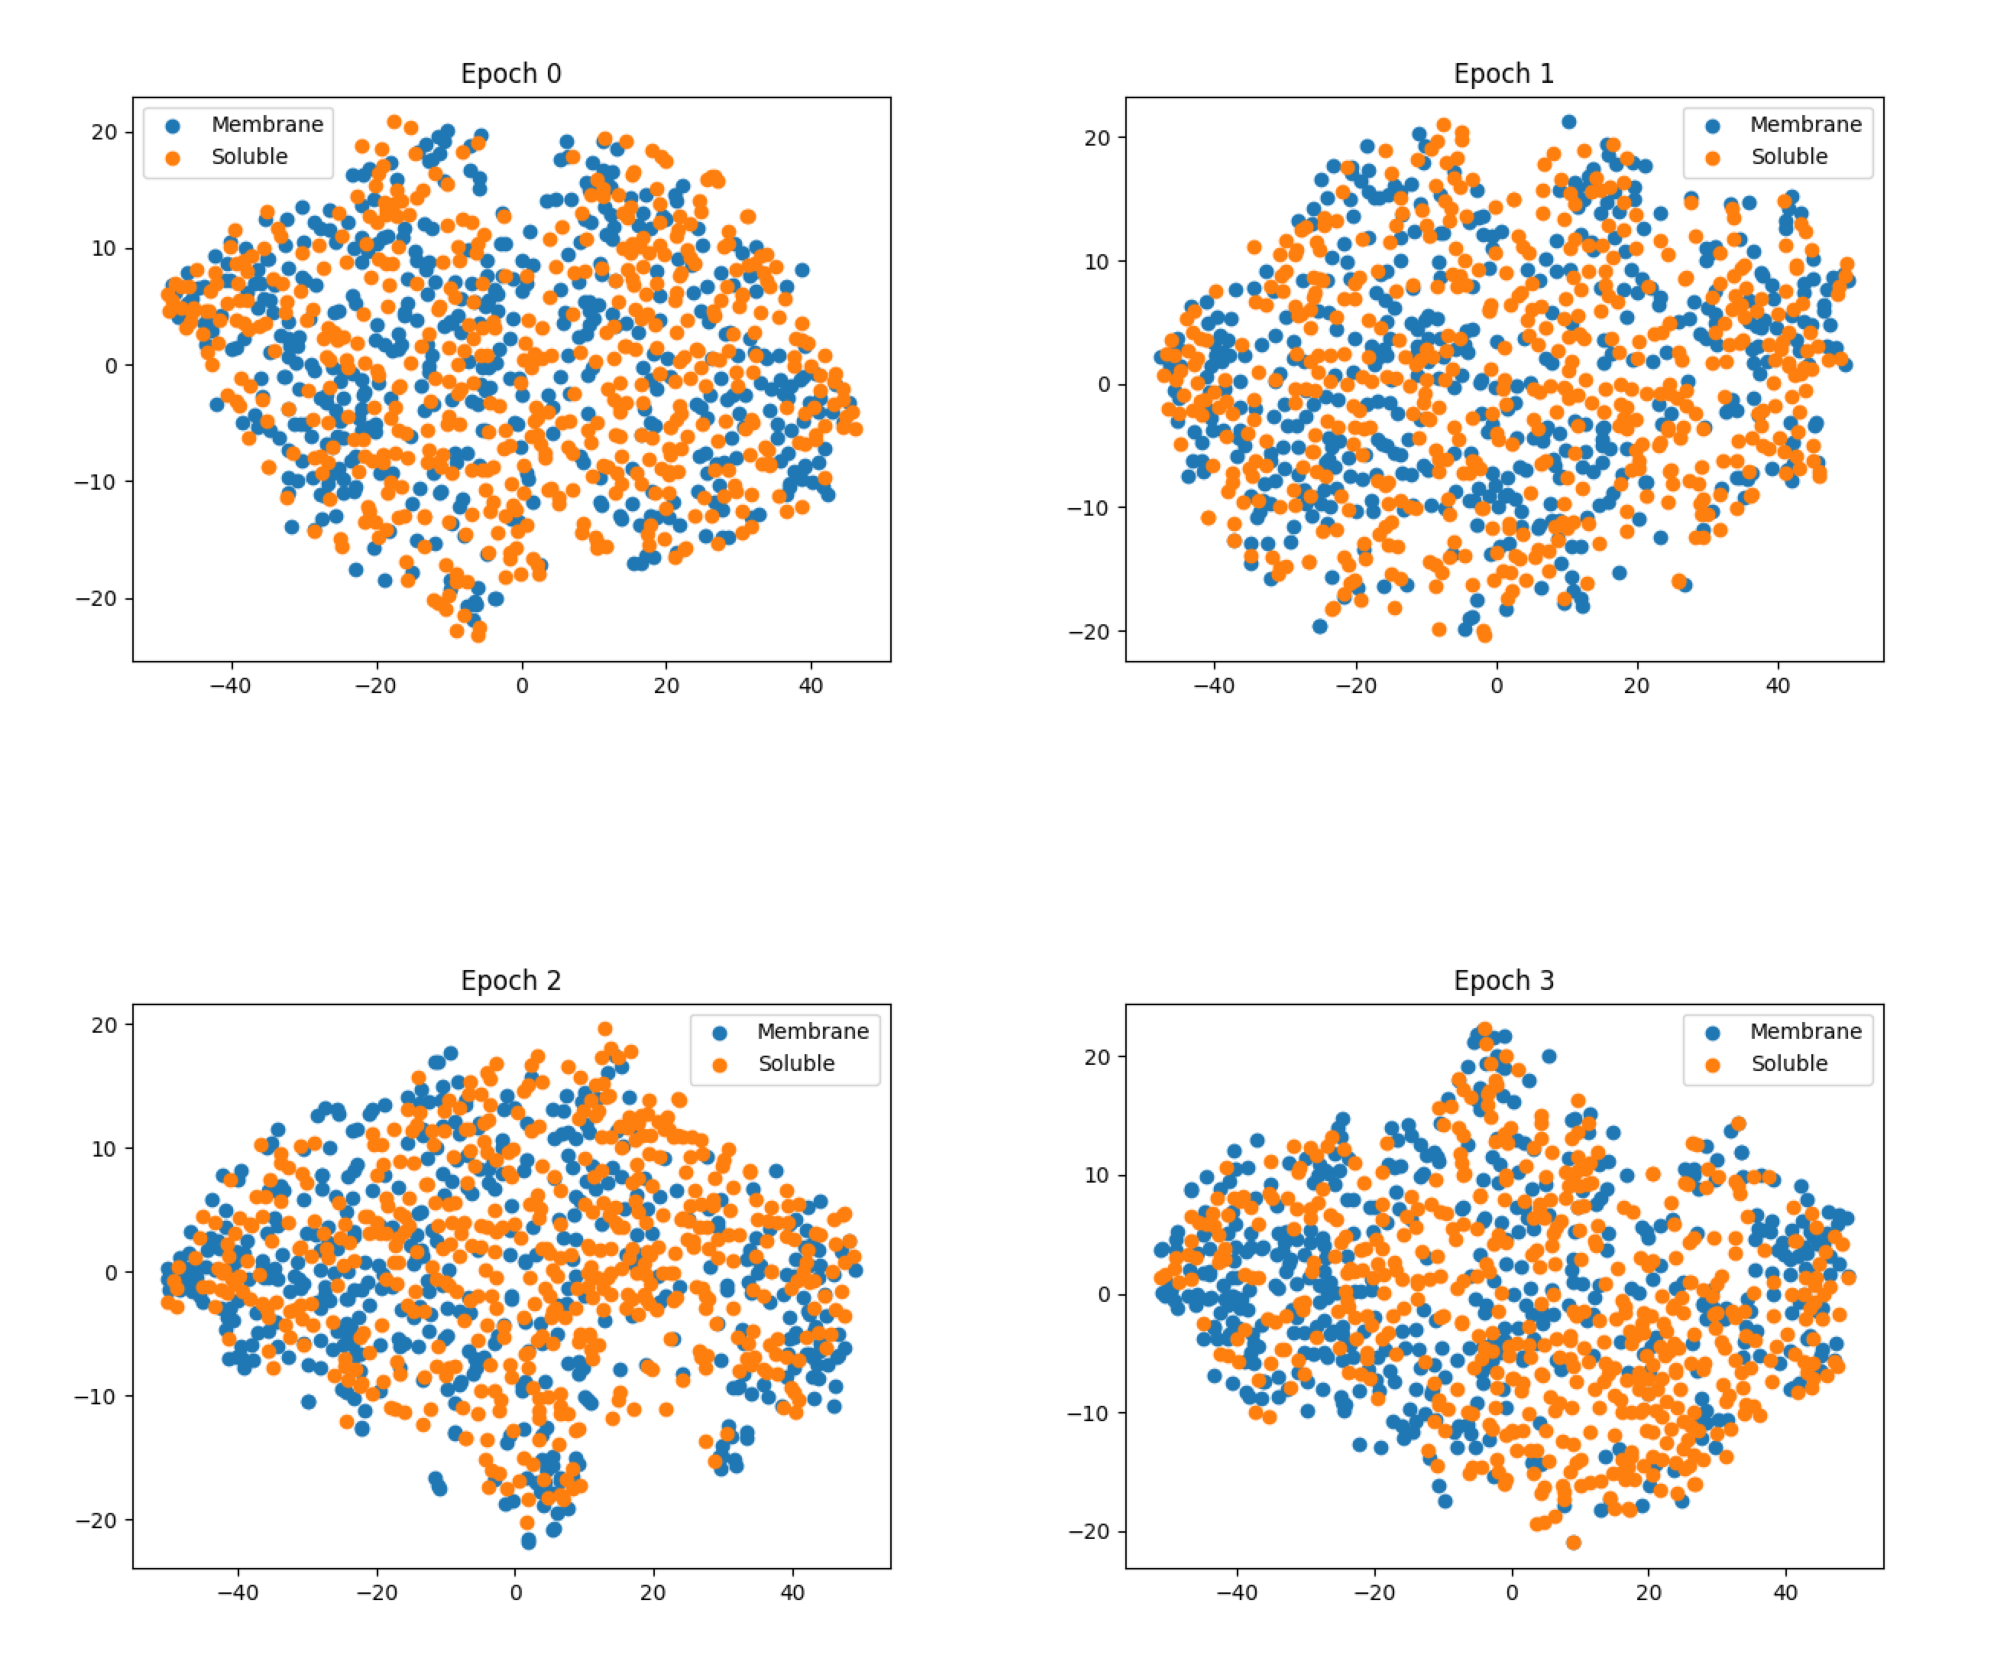

/home/macaulay/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.8636363636363636
Confusion Matrix: 
 [[118  18]
 [ 21 129]]
Classification Report: 
               precision    recall  f1-score   support

    Membrane       0.85      0.87      0.86       136
     Soluble       0.88      0.86      0.87       150

    accuracy                           0.86       286
   macro avg       0.86      0.86      0.86       286
weighted avg       0.86      0.86      0.86       286



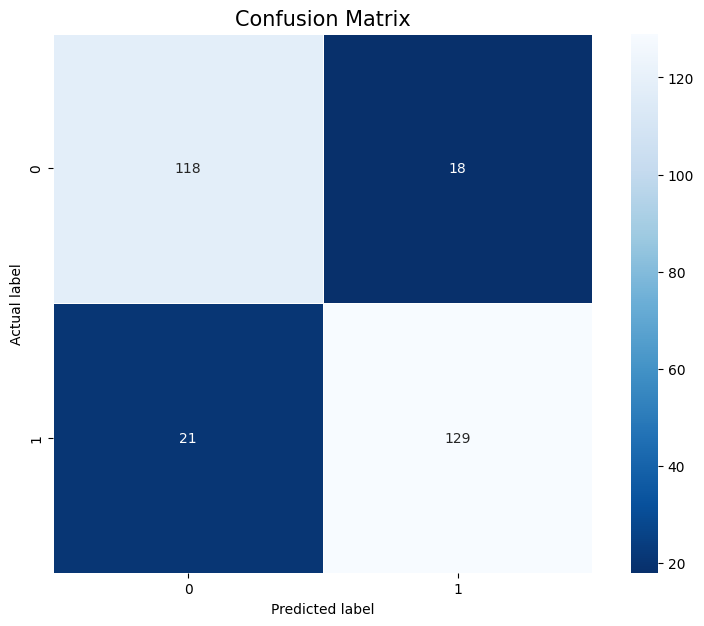

/home/macaulay/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/macaulay/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


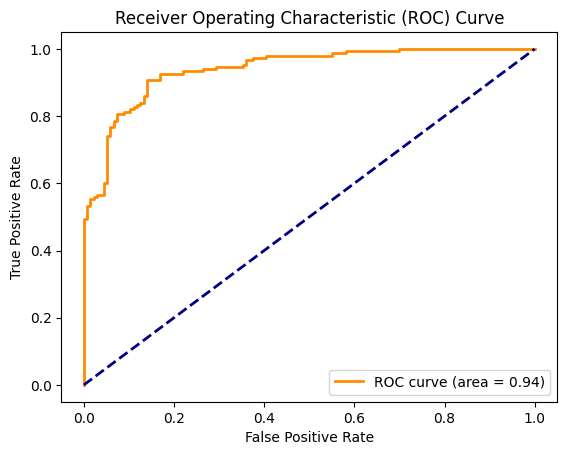

Attaching SeuratObject
******************************************

*                                        *

*          Welcome to WebGestaltR !      *

*                                        *

******************************************

Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Warning messages:
1: In eval(predvars, data, env) : NaNs produced
2: In hvf.info$variance.expected[not.const] <- 10^fit$fitted :
  number of items to replace is not a multiple of replacement length
Centering and scaling data matrix
  |======================================================================| 100%
To use Python UMAP via reticulate, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1431
Number of edges: 44080

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7682
Number of communities: 6
Elapsed time: 0 seconds
null device 
          1 
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Generate the final report...
Results can be found in the data/solubility/enrichment_analysis/GeneLLM_all/Project_data_solubility_enrichment_analysis_Reactome_cluster0!
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover.

Warning message:
In oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum,  :
  No significant gene set is identified based on FDR 0.05!


null device 
          1 


In [74]:

#########################################----------Edit only this part---- Filepath & tasktype ----------------######################################################################

input_data_path = 'data/solubility.csv'
task_type = "classification"
task_name = "solubility"

#########################################----------Run----------------######################################################################

analyze(input_data_path, task_type, task_name)

# plot the tsne of annotated embeddings based on its annotation

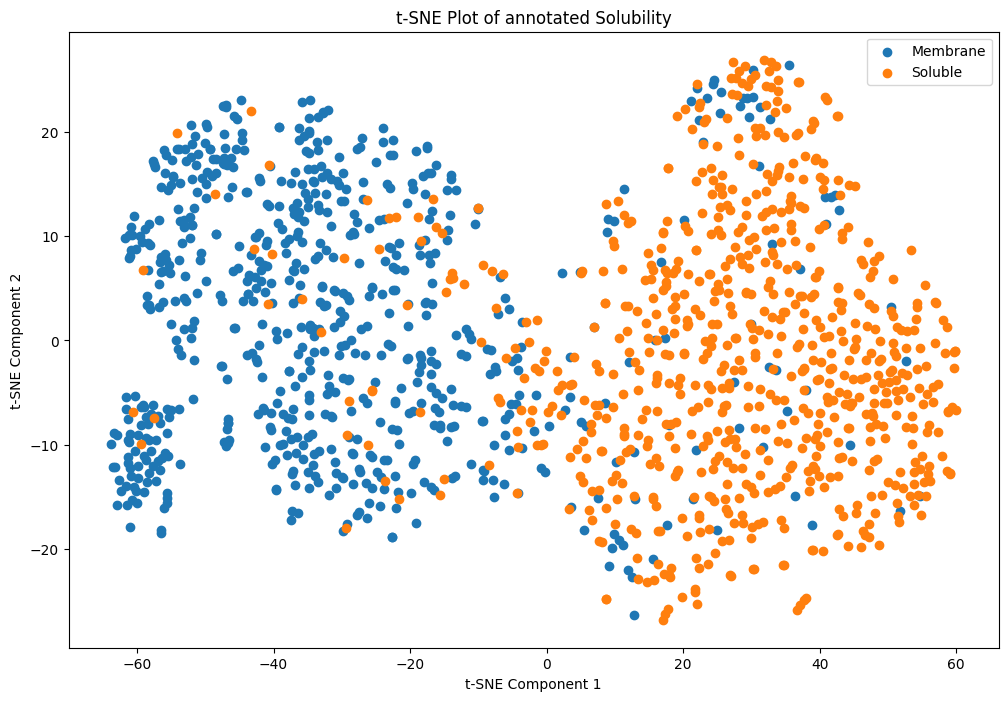

In [116]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

df_solub_annot = pd.read_csv('data/solubility.csv')
gene_solu_emb = pd.read_csv('data/solubility/fine_tuned_embeddings_solubility.csv', header=None)
gene_solu_emb.columns = ['GeneSymbol'] + [f'Col_{i}' for i in range(1, len(gene_solu_emb.columns))]
merged_df = pd.merge(df_solub_annot, gene_solu_emb, on='GeneSymbol', how='left')
merged_df = merged_df.dropna()

features = merged_df.loc[:, 'Col_1':'Col_1024']
# Applying t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(features)

# Creating a scatter plot
plt.figure(figsize=(12, 8))
for solubility_category in merged_df['Solubility'].unique():
    indices = merged_df['Solubility'] == solubility_category
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=solubility_category)

plt.legend()
plt.title('t-SNE Plot of annotated Solubility')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# predict solubility of unannotated genes using the models trained on annotated genes

In [89]:
genes = loading_unlabeled_data('data/solubility_unannotated.csv')
task_name = 'solubility'
task_type = "classification"
n_labels = 2
model_file_path = f"data/{task_name}/logistic_regression_model_{task_name}.pkl"

df_new = generate_finetuned_embeddings_for_unlabelled_genes(genes, pool = "cls", max_length= 100, batch_size =100, drop_rate =0.1,
                gene2vec_flag = None, gene2vec_hidden = 200, device = "cuda",
                task_type = "classification", n_labels  = n_labels, model_name= "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract", task_name = task_name)

model = joblib.load(model_file_path)
df_new = pd.read_csv(f'data/fine_{task_name}.csv')
X_new = df_new.iloc[:, 1:]

# Make predictions
predictions = model.predict(X_new)

predictions_df = pd.DataFrame(predictions, columns=['Solubility'])
predictions_df['GeneSymbol'] = df_new['GeneSymbol'].values
predictions_df = predictions_df[['GeneSymbol', 'Solubility']]
predictions_df.to_csv('data/solubility_unannotated_predictions.csv', index=False)    
predictions_df    


KeyboardInterrupt: 

# plot tsne of predicted solubility 

/tmp/ipykernel_2505452/2519782060.py:6: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,2

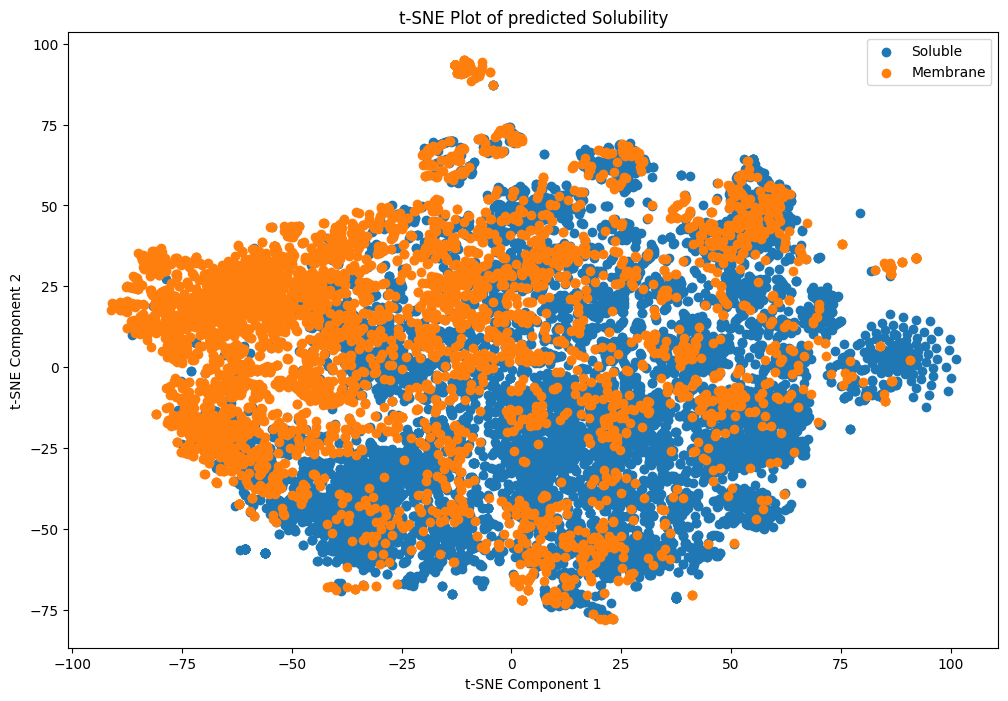

In [117]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

df_solub_annot = pd.read_csv('data/solubility_unannotated_predictions.csv')
gene_solu_emb = pd.read_csv('data/fine_solubility.csv', header=None)
gene_solu_emb.columns = ['GeneSymbol'] + [f'Col_{i}' for i in range(1, len(gene_solu_emb.columns))]
merged_df_unannotated = pd.merge(df_solub_annot, gene_solu_emb, on='GeneSymbol', how='left')
merged_df_unannotated = merged_df_unannotated.dropna()

features = merged_df_unannotated.loc[:, 'Col_1':'Col_1024']
# Applying t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(features)

# Creating a scatter plot
plt.figure(figsize=(12, 8))
for solubility_category in merged_df_unannotated['Solubility'].unique():
    indices = merged_df_unannotated['Solubility'] == solubility_category
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=solubility_category)

plt.legend()
plt.title('t-SNE Plot of predicted Solubility')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# Applying UMAP
#umap_results = umap.UMAP(n_components=2, random_state=0).fit_transform(features)

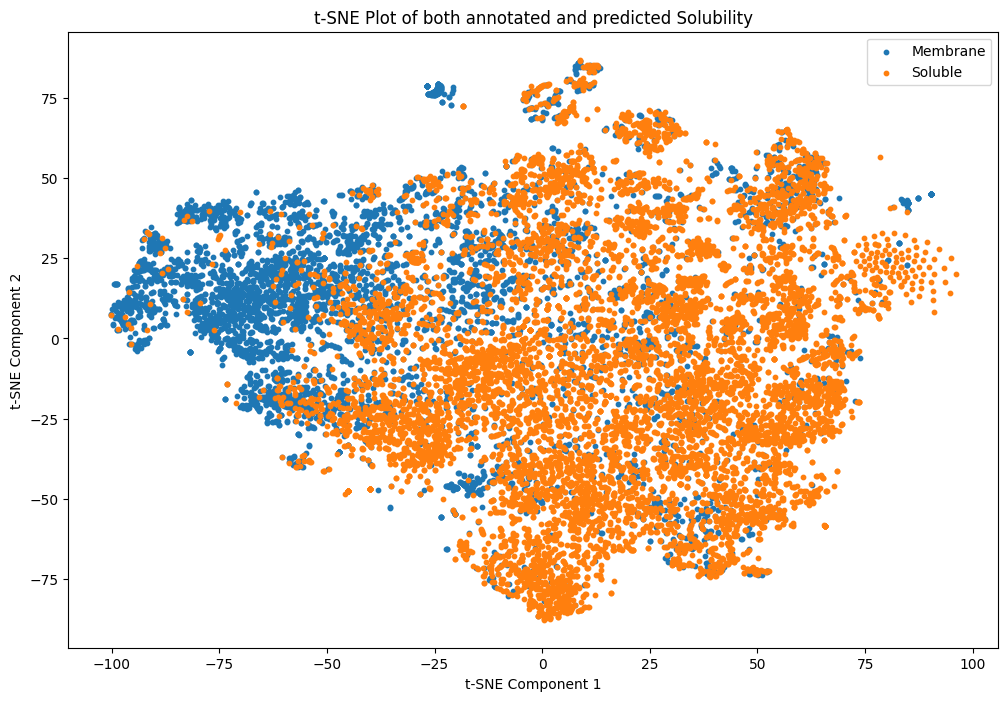

In [118]:
merging = pd.concat([merged_df, merged_df_unannotated], axis=0)


features = merging.loc[:, 'Col_1':'Col_1024']

# Applying t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(features)

# Creating a scatter plot
plt.figure(figsize=(12, 8))
for solubility_category in merging['Solubility'].unique():
    indices = merging['Solubility'] == solubility_category
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=solubility_category, s = 10)

plt.legend()
plt.title('t-SNE Plot of both annotated and predicted Solubility')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Bias

In [20]:
genes = loading_unlabeled_data('data/solubility_unannotated.csv')
task_name = 'solubility'
task_type = "classification"
n_labels = 2
model_file_path = f"data/{task_name}/logistic_regression_model_{task_name}.pkl"

df_new = generate_finetuned_embeddings_for_unlabelled_genes(genes, pool = "cls", max_length= 100, batch_size =100, drop_rate =0.1,
                gene2vec_flag = None, gene2vec_hidden = 200, device = "cuda",
                task_type = "classification", n_labels  = n_labels, model_name= "microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract", task_name = task_name)

model = joblib.load(model_file_path)
df_new = pd.read_csv(f'data/fine_{task_name}.csv')
X_new = df_new.iloc[:, 1:]

# Make predictions
predictions = model.predict(X_new)

predictions_df = pd.DataFrame(predictions, columns=['Solubility'])
predictions_df['GeneSymbol'] = df_new['GeneSymbol'].values
predictions_df = predictions_df[['GeneSymbol', 'Solubility']]
predictions_df.to_csv('data/solubility_unannotated_predictions.csv', index=False)    
predictions_df   

Gene name                                            Summary
0              FES  This gene encodes the human cellular counterpa...
1           SLC7A7  The protein encoded by this gene is the light ...
2            HSPA2  Enables disordered domain specific binding act...
3           ZSCAN9  Enables sequence-specific double-stranded DNA ...
4          SEPTIN3  This gene encodes a member of the sorting nexi...
...            ...                                                ...
14296  IQCJ-SCHIP1  C19orf25 (Chromosome 19 Open Reading Frame 25)...
14297        BPY2C  This gene is located in the nonrecombining por...
14298         DNER  The protein encoded by this gene is a cofactor...
14299         SOX7  Predicted to enable Notch binding activity. In...
14300       CXCL14  This gene encodes a member of the SOX (SRY-rel...

[14301 rows x 2 columns]

Fine-tuned embeddings saved to data/fine_solubility.csv


GeneSymbol     Col_1     Col_2     Col_3     Col_4     Col_5  \
0              FES  0.977115 -0.056968 -0.014919 -0.353433  0.144711   
1           SLC7A7  0.997584  0.981466  0.657633 -0.289879  0.076314   
2            HSPA2  0.291824 -0.944040 -0.105381  0.205969 -0.125913   
3           ZSCAN9  0.706149 -0.852117 -0.009921  0.017956  0.043246   
4          SEPTIN3  0.987716  0.231037 -0.184549 -0.145114 -0.093823   
...            ...       ...       ...       ...       ...       ...   
14296  IQCJ-SCHIP1 -0.262526 -0.965564 -0.155519 -0.145781  0.263430   
14297        BPY2C  0.037251 -0.966223 -0.436817 -0.106845 -0.028248   
14298         DNER  0.929663 -0.535325  0.070750 -0.386048 -0.136483   
14299         SOX7  0.914309 -0.849164  0.096854 -0.079673  0.452759   
14300       CXCL14  0.712030 -0.750571 -0.021339  0.013732  0.337880   

          Col_6     Col_7     Col_8     Col_9  ...  Col_1015  Col_1016  \
0      0.128199 -0.991777 -0.412586  0.992095  ...  0.519316  0.033179   
1      0.161375 -0.915489 -0.129363  0.963075  ... -0.212308 -0.080988   
2     -0.329930 -0.515378 -0.188990  0.970557  ...  0.207481 -0.427193   
3      0.180170 -0.882911 -0.173601  0.970913  ...  0.326236 -0.361557   
4      0.307444 -0.288173 -0.197672  0.927474  ...  0.308460 -0.132265   
...         ...       ...       ...       ...  ...       ...       ...   
14296  0.211484 -0.873884 -0.271728  0.982986  ... -0.021413 -0.184269   
14297  0.030194 -0.876712  0.439705  0.909990  ...  0.341321 -0.448997   
14298  0.037117 -0.896040  0.158063  0.855398  ... -0.246519  0.182640   
14299  0.217703 -0.311517  0.182858  0.747946  ...  0.266952 -0.121453   
14300  0.008352 -0.266555 -0.174276  0.905332  ...  0.255149 -0.223871   

       Col_1017  Col_1018  Col_1019  Col_1020  Col_1021  Col_1022  Col_1023  \
0     -0.999713 -0.008190  0.877587 -0.178617  0.989345 -0.407888 -0.032041   
1     -0.993670 -0.576222 -0.797116  0.168669 -0.978249 -0.428167  0.592644   
2     -0.973413  0.426451  0.982193 -0.147798  0.825458  0.024385 -0.172463   
3     -0.995700  0.019831  0.817748 -0.214124  0.510095 -0.050574  0.165245   
4     -0.993645  0.093128  0.901359  0.392339 -0.647371 -0.400882  0.046990   
...         ...       ...       ...       ...       ...       ...       ...   
14296 -0.959963  0.195860  0.973381 -0.088775  0.872142  0.006989  0.001523   
14297 -0.770019  0.144462  0.987026 -0.320866  0.975729 -0.005247 -0.048240   
14298 -0.988437 -0.373606  0.966674 -0.048342 -0.108672  0.171811 -0.184520   
14299 -0.961231 -0.167860  0.721643  0.006971  0.926839 -0.196857  0.278453   
14300 -0.953936  0.166707  0.729494 -0.272872  0.720646 -0.142772 -0.462755   

       Col_1024  
0     -0.957704  
1     -0.989275  
2     -0.521153  
3     -0.582945  
4     -0.953763  
...         ...  
14296  0.468864  
14297  0.165216  
14298 -0.984165  
14299 -0.596787  
14300 -0.663508  

[14301 rows x 1025 columns]

GeneSymbol Solubility
0              FES    Soluble
1           SLC7A7   Membrane
2            HSPA2   Membrane
3           ZSCAN9    Soluble
4          SEPTIN3   Membrane
...            ...        ...
14296  IQCJ-SCHIP1    Soluble
14297        BPY2C    Soluble
14298         DNER    Soluble
14299         SOX7    Soluble
14300       CXCL14    Soluble

[14301 rows x 2 columns]

: 

# Get list of unlabelled data

In [54]:
import pandas as pd
df = pd.read_csv('data/genes.csv')
df_solub_annot = pd.read_csv('data/solubility.csv')
df_genes = df[['Gene name']]
genes_df_genes = set(df_genes['Gene name'])
genes_df_solub_annot = set(df_solub_annot['GeneSymbol'])
uncommon_genes = genes_df_genes.symmetric_difference(genes_df_solub_annot)
uncommon_genes_df = pd.DataFrame(uncommon_genes, columns=['GeneSymbol'])
uncommon_genes_df.to_csv('data/solubility_unannotated.csv', index=False)
uncommon_genes_df

Gene name
0           FES
1        HADHA 
2        SLC7A7
3          LCK 
4         HSPA2
...         ...
16588     BPY2C
16589      CLPS
16590      DNER
16591      SOX7
16592    CXCL14

[16593 rows x 1 columns]

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

gene_solu_emb = pd.read_csv('data/solubility/fine_tuned_embeddings_solubility.csv', header=None)
print(len(gene_solu_emb))

1431


# plot the tsne of annotated embeddings

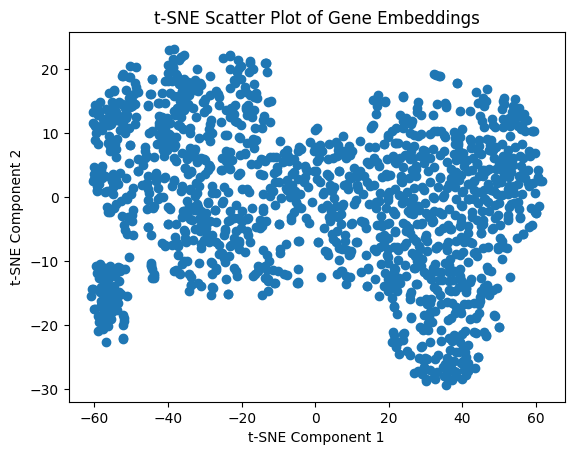

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

gene_solu_emb = pd.read_csv('data/solubility/fine_tuned_embeddings_solubility.csv', header=None)
print(len(gene_solu_emb))
gene_solu_emb = gene_solu_emb.iloc[:, 1:]

# Perform t-SNE to reduce the dimensionality to 2 components
tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(gene_solu_emb)

# Create a scatter plot
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1])
plt.title('t-SNE Scatter Plot of Gene Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# plot the tsne of annotated embeddings based on its annotation

/home/macaulay/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


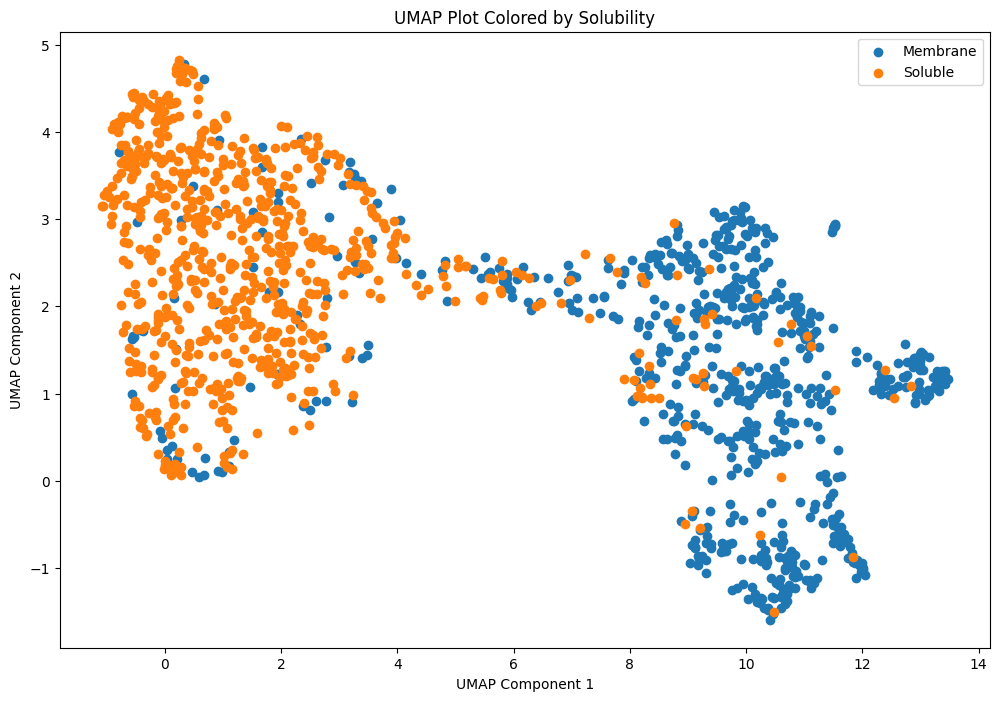

In [100]:

import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

df_solub_annot = pd.read_csv('data/solubility.csv')
gene_solu_emb = pd.read_csv('data/solubility/fine_tuned_embeddings_solubility.csv', header=None)
gene_solu_emb.columns = ['GeneSymbol'] + [f'Col_{i}' for i in range(1, len(gene_solu_emb.columns))]
merged_df = pd.merge(df_solub_annot, gene_solu_emb, on='GeneSymbol', how='left')
merged_df = merged_df.dropna()

features = merged_df.loc[:, 'Col_1':'Col_1024']

# Applying UMAP
umap_results = umap.UMAP(n_components=2, random_state=0).fit_transform(features)

# Creating a scatter plot
plt.figure(figsize=(12, 8))
for solubility_category in merged_df['Solubility'].unique():
    indices = merged_df['Solubility'] == solubility_category
    plt.scatter(umap_results[indices, 0], umap_results[indices, 1], label=solubility_category)

plt.legend()
plt.title('UMAP Plot Colored by Solubility')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

## Gene Expression

In [ ]:
#########################################----------Edit only this part---- Filepath & tasktype ----------------######################################################################

input_data_path = 'data/gene_expression.csv'
task_type = "regression"
task_name = "gene_expression"

#########################################----------Run----------------######################################################################

analyze(input_data_path, task_type, task_name)

## Use NuSVR to build a model on the finetuned embeddings

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.svm import SVR, NuSVR, LinearSVR
from scipy.stats import pearsonr
from sklearn.svm import NuSVR


df = pd.read_csv('/home/macaulay/macaulay/GeneLLM/data/gene_expression.csv')
df1 = pd.read_csv('/home/macaulay/macaulay/GeneLLM/data/fine_tuned_embeddings_gene_expression.csv')

merged_df = df1.merge(df, left_on='gene_name', right_on='GeneSymbol', how='inner')



merged_df.drop(['gene_name'], axis=1, inplace=True)
merged_df['gene_expression'] = merged_df.iloc[:, -1]
last_col_name = merged_df.columns[-2]  
merged_df.drop(columns=[last_col_name], inplace=True)
X = merged_df.drop('gene_expression', axis=1)
y = merged_df['gene_expression']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a NuSVR model with the specified hyperparameters
nu_svr = NuSVR(C=0.1, kernel='linear')

# Train the NuSVR model
nu_svr.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = nu_svr.predict(X_test_scaled)

# Calculate R-squared (coefficient of determination)
r2 = r2_score(y_test, y_pred)

# Calculate Pearson correlation coefficient and p-value
pearson_corr, pearson_p_value = pearsonr(y_test, y_pred)

print(f"{i}/{len(df)} R^2 Score on Test Set: {r2:.4f}")
print(f"{i}/{len(df)} Pearson's Correlation Coefficient: {pearson_corr:.4f}")
print(f"{i}/{len(df)} Pearson's P-value: {pearson_p_value:.4f}")
# with open('datas/regression_result_essentiality_finetuned.tsv', 'a') as cu:
#     cu.write(f'{cell_name}\t{pearson_corr:.4f}\t{r2:.4f}\t{pearson_p_value:.4f}\n')
    
    





3/19193 R^2 Score on Test Set: 0.6235
3/19193 Pearson's Correlation Coefficient: 0.7917
3/19193 Pearson's P-value: 0.0000


## Plot the regression line

/tmp/ipykernel_2853539/1831328452.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([sampled_y_test.min(), sampled_y_test.max()], [sampled_y_test.min(), sampled_y_test.max()], 'k--', lw=3, color='red', label='Regression Line')


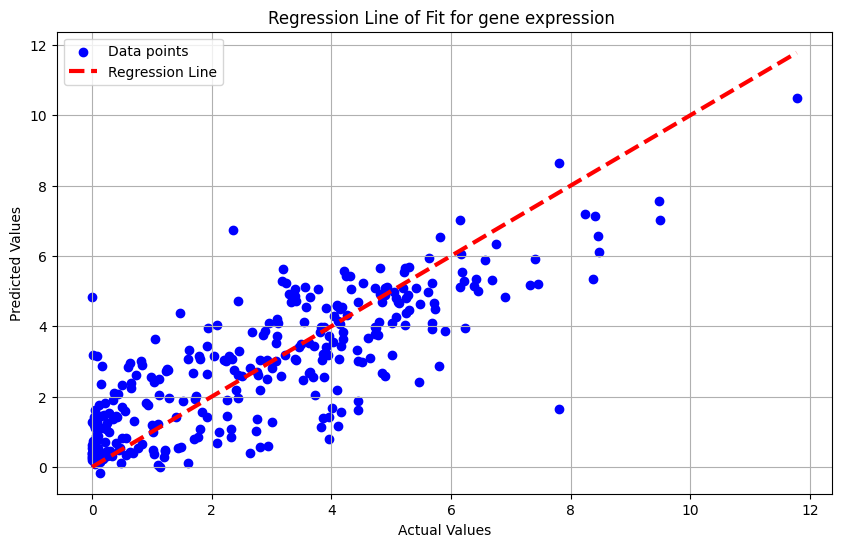

In [ ]:
# Select one in every 10 values
sampled_y_test = y_test[::10]
sampled_y_pred = y_pred[::10]

plt.figure(figsize=(10, 6))
plt.scatter(sampled_y_test, sampled_y_pred, color='blue', label='Data points')
plt.plot([sampled_y_test.min(), sampled_y_test.max()], [sampled_y_test.min(), sampled_y_test.max()], 'k--', lw=3, color='red', label='Regression Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Regression Line of Fit for gene expression ')
plt.legend()
plt.grid(True)
# plt.xlim(1, 12)  # Setting x-axis limits
# plt.ylim(1, 12)  # Setting y-axis limits
plt.show()


## MAP KINASE

Number of mapkinase labels: 2


Gene name                                            Summary  \
0       HSPA2  Enables disordered domain specific binding act...   
1       FGF12  This gene encodes the homolog of the Drosophil...   
2       FGF20  This gene encodes a member of the kelch family...   
3        RTF2  The protein encoded by this gene is a member o...   
4       FGF18  ST6GALNAC2 belongs to a family of sialyltransf...   
..        ...                                                ...   
492    PLA2G3  This gene encodes a member of the neurexophili...   
493   CACNA1E  Ubiquinone also known as coenzyme Q or Q is a ...   
494    SLC2A4  This gene is a member of the solute carrier fa...   
495   OPN1MW2  Enables sequence-specific double-stranded DNA ...   
496  MAPK8IP3  The protein encoded by this gene shares simila...   

                                          Interactions  \
0                                                  NaN   
1                                                  NaN   
2    The sequence BAB14199.1 differs from that show...   
3    Homodimer.Interacts with FGFR2 and FGFR4.Affin...   
4    Aberrant O-galactosylation of IgA1 molecules p...   
..                                                 ...   
492  The sequence AAQ13637.1 differs from that show...   
493  Component of a multi-subunit COQ enzyme comple...   
494                                                NaN   
495                                                NaN   
496                                                NaN   

                           Mapkinase  Label  
0    NON MAPK Signaling Pathway GENE      0  
1        MAPK Signaling Pathway GENE      1  
2        MAPK Signaling Pathway GENE      1  
3    NON MAPK Signaling Pathway GENE      0  
4        MAPK Signaling Pathway GENE      1  
..                               ...    ...  
492      MAPK Signaling Pathway GENE      1  
493      MAPK Signaling Pathway GENE      1  
494  NON MAPK Signaling Pathway GENE      0  
495  NON MAPK Signaling Pathway GENE      0  
496      MAPK Signaling Pathway GENE      1  

[497 rows x 5 columns]

Shape of tokens_df before gene2vec:(497, 6)
Shape of tokens_df after gene2vec:(497, 6)
Data saved to data/mapkinase/val_test_split_mapkinase.json
model :microsoft/BiomedNLP-PubMedBERT-large-uncased-abstract, gene2vec: False
Shape of tokens_df before gene2vec:(497, 6)
Shape of tokens_df after gene2vec:(497, 6)

#############################
Currently running mapkinase.
#############################



/home/macaulay/.local/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 3
-------------------------------
Training ...
torch.Size([337, 1024])
Validation ...
Testing ...
	ET: 27.63 Seconds
Train Loss: 0.7031, Accuracy: 0.4985, F1: 0.462, Precision: 0.5584, Recall: 0.4985
Val Loss: 0.6914, Accuracy: 0.4824, F1: 0.4812, Precision: 0.5156, Recall: 0.4824
Test Loss: 0.6928, Accuracy: 0.5333, F1: 0.5333, Precision: 0.5778, Recall: 0.5333
best_epoch_num: 1
Epoch 2 of 3
-------------------------------
Training ...
torch.Size([337, 1024])
Validation ...
Testing ...
	ET: 27.89 Seconds
Train Loss: 0.6765, Accuracy: 0.5697, F1: 0.5547, Precision: 0.5586, Recall: 0.5697
Val Loss: 0.6672, Accuracy: 0.6118, F1: 0.5623, Precision: 0.5998, Recall: 0.6118
Test Loss: 0.6648, Accuracy: 0.6133, F1: 0.5843, Precision: 0.5945, Recall: 0.6133
best_epoch_num: 2
Epoch 3 of 3
-------------------------------
Training ...
torch.Size([337, 1024])
Validation ...
Testing ...
	ET: 28.29 Seconds
Train Loss: 0.6564, Accuracy: 0.6231, F1: 0.5593, Precision: 0.6641, Recall: 0.6231

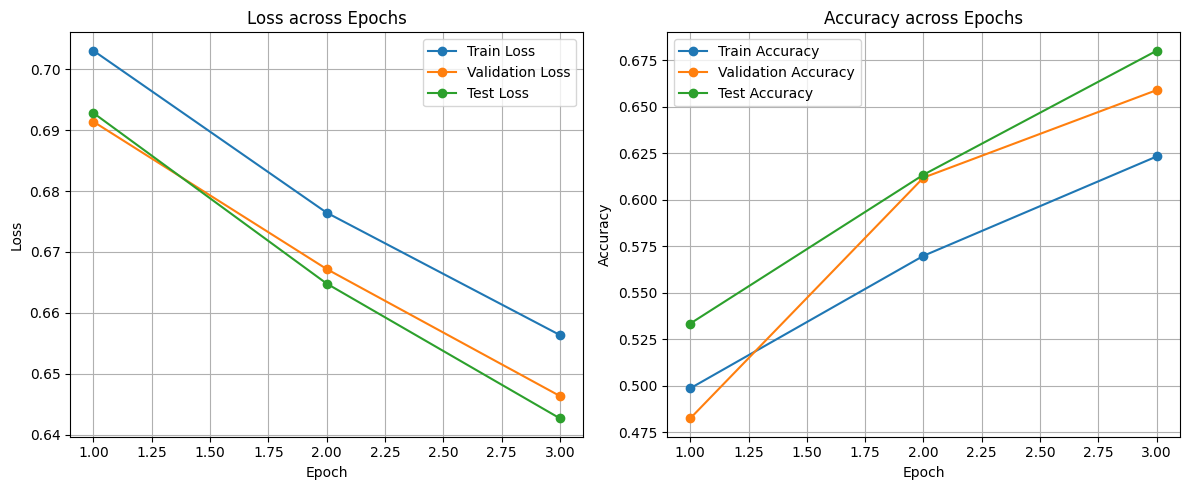

Fine-tuned embeddings saved to data/mapkinase/fine_tuned_embeddings_mapkinase.csv
best epoch number: 3


/home/macaulay/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.86
Confusion Matrix: 
 [[36  6]
 [ 8 50]]
Classification Report: 
                                  precision    recall  f1-score   support

    MAPK Signaling Pathway GENE       0.82      0.86      0.84        42
NON MAPK Signaling Pathway GENE       0.89      0.86      0.88        58

                       accuracy                           0.86       100
                      macro avg       0.86      0.86      0.86       100
                   weighted avg       0.86      0.86      0.86       100



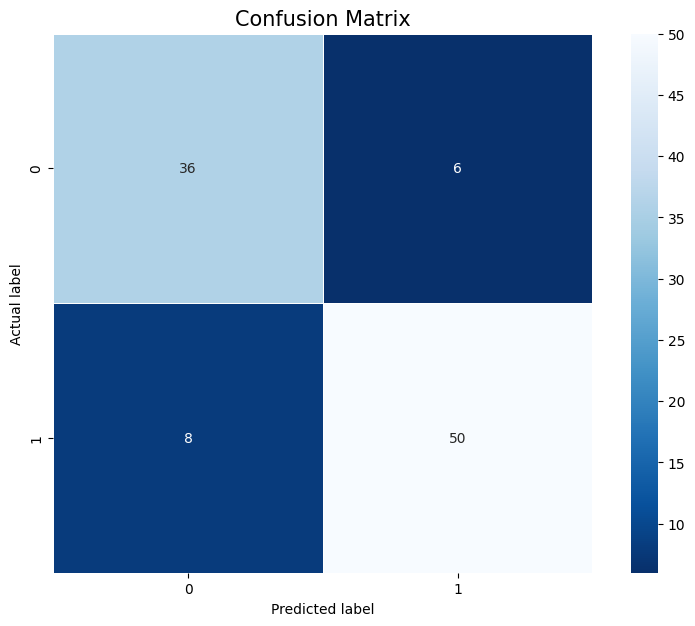

/home/macaulay/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/macaulay/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


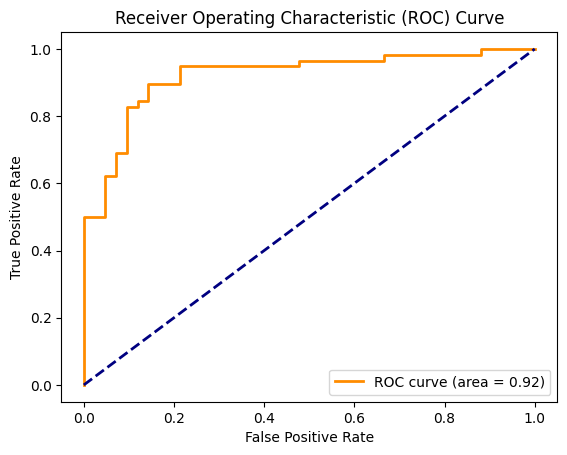

Attaching SeuratObject
******************************************

*                                        *

*          Welcome to WebGestaltR !      *

*                                        *

******************************************

Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Warning messages:
1: In eval(predvars, data, env) : NaNs produced
2: In hvf.info$variance.expected[not.const] <- 10^fit$fitted :
  number of items to replace is not a multiple of replacement length
Centering and scaling data matrix
  |======================================================================| 100%
To use Python UMAP via reticulate, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 497
Number of edges: 15915

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6760
Number of communities: 5
Elapsed time: 0 seconds


0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|


null device 
          1 
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Begin affinity propagation...
End affinity propagation...
Begin weighted set cover...
Remain is 0, ending weighted set cover
Generate the final report...
Results can be found in the data/mapkinase/enrichment_analysis/GeneLLM_all/Project_data_mapkinase_enrichment_analysis_Reactome_cluster0!
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing the enrichment analysis...
Loading the functional categories...
Loading the ID list...
Loading the reference list...
Summarizing the input ID list by GO Slim data...
Performing th

Warning messages:
1: In oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum,  :
  No significant gene set is identified based on FDR 0.05!
2: In oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum,  :
  No significant gene set is identified based on FDR 0.05!
3: In oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum,  :
  No significant gene set is identified based on FDR 0.05!
4: In oraEnrichment(interestGeneList, referenceGeneList, geneSet, minNum = minNum,  :
  No significant gene set is identified based on FDR 0.05!


null device 
          1 


In [10]:
#########################################----------Edit only this part---- Filepath & tasktype ----------------######################################################################

input_data_path = 'data/mapkinase.csv'
task_type = "classification"
task_name = "mapkinase"

#########################################----------Run----------------######################################################################

analyze(input_data_path, task_type, task_name)

In [23]:
y

Mapkinase
0    NON MAPK Signaling Pathway GENE
1        MAPK Signaling Pathway GENE
2        MAPK Signaling Pathway GENE
3    NON MAPK Signaling Pathway GENE
4        MAPK Signaling Pathway GENE
..                               ...
511  NON MAPK Signaling Pathway GENE
512  NON MAPK Signaling Pathway GENE
513      MAPK Signaling Pathway GENE
514  NON MAPK Signaling Pathway GENE
515      MAPK Signaling Pathway GENE

[496 rows x 1 columns]

In [ ]:
print(y.columns)

In [ ]:
print(y.columns)

## Use Logistic Regression to build a model on the finetuned embeddings

Accuracy: 0.93
Confusion Matrix: 
 [[36  6]
 [ 1 57]]
Classification Report: 
                                  precision    recall  f1-score   support

    MAPK Signaling Pathway GENE       0.97      0.86      0.91        42
NON MAPK Signaling Pathway GENE       0.90      0.98      0.94        58

                       accuracy                           0.93       100
                      macro avg       0.94      0.92      0.93       100
                   weighted avg       0.93      0.93      0.93       100



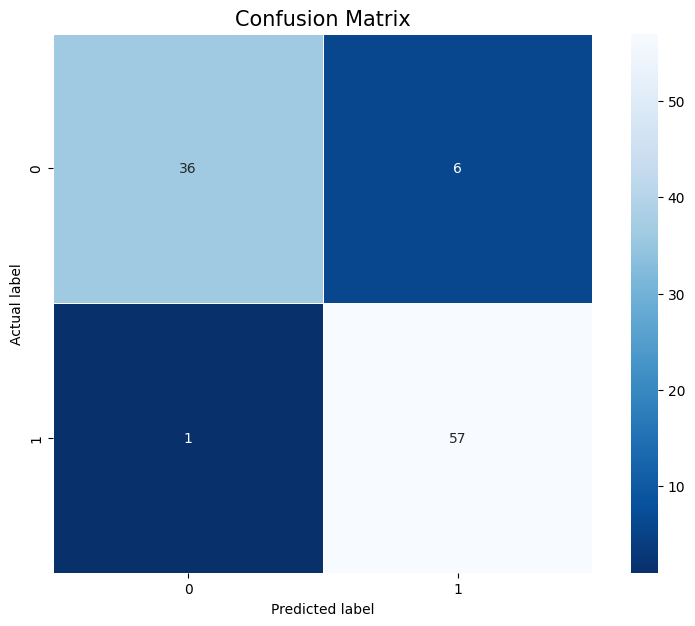

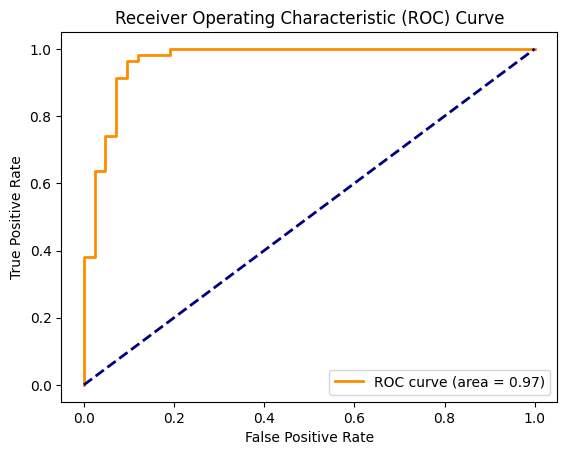

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

####################################################################################################################################

df_ft = pd.read_csv('data/fine_tuned_embeddings_Mapkinase.csv')
df_ft_label = pd.read_csv('data/mapkinase.csv')

####################################################################################################################################
merged_data = df_ft.merge(df_ft_label, left_on='gene_name', right_on='GeneSymbol', how='inner')

# Assuming merged_data is loaded beforehand
X = merged_data.iloc[:, :-3]
y = merged_data.iloc[:, -1]


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the model with the best parameters
model = LogisticRegression(C=1, max_iter=1000)

# Fit the model
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)

# Print the accuracy
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# Print the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n {conf_mat}")

# Print the classification report
print(f"Classification Report: \n {classification_report(y_test, y_pred)}")

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix', size=15)
plt.show()

# Calculate the probabilities
probabilities = model.predict_proba(X_test)

# Create a label encoder instance
label_encoder = LabelEncoder()

# Fit the encoder on the entire target data
label_encoder.fit(y)

# Transform y_test and y_pred to binary or multi-class format
encoded_y_test = label_encoder.transform(y_test)

# Check the number of unique labels
unique_labels = y.unique()

if len(unique_labels) == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(encoded_y_test, probabilities[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

else:
    # Multi-class classification
    # One-vs-all ROC AUC curves
    n_classes = len(unique_labels)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((encoded_y_test == i).astype(int), probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


### Word distribution

In [7]:
input_data_path = 'data/solubility.csv'
task_type = "classification"


genes, n_labels = loading_data(input_data_path, task_type)
print(f'Number of labels: {n_labels}')
display(genes)


num_words_per_sentence = []

for summary in genes["Summary"]:
    for sent in sent_tokenize(summary):
        num_words_per_sentence.append(len(sent.split()))
        

num_sent_per_sentence = [len(sent_tokenize(sentence)) for sentence in genes["Summary"]]

plt.hist(num_words_per_sentence)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Words in Sentences')
plt.show()

Number of labels: 2


Gene name                                            Summary  \
0        ERAP2  The protein encoded by this gene belongs to th...   
1     ADAMTSL5  The product of the MND1 gene associates with H...   
2      TBC1D30  Predicted to act upstream of or within with a ...   
3       KCNK18  Enables GTPase activator activity and small GT...   
4         NDNF  Human platelet glycoprotein V (GP5) is a part ...   
...        ...                                                ...   
1426      RPS9  Ribosomes the organelles that catalyze protein...   
1427     NBPF1  Olfactory receptors interact with odorant mole...   
1428  SLC22A16  Predicted to be involved in protein transport ...   
1429      FBN3  Enables N-(long-chain-acyl)ethanolamine deacyl...   
1430      BDH2  This gene encodes an alpha integrin. Integrins...   

                                           Interactions Solubility  Label  
0                        Interacts with IGFN1 and FLNC.   Membrane      0  
1     Heterodimer with PSMC3IP/HOP2.MND1-PSMC3IP int...    Soluble      1  
2     The sequence AAD34068.1 differs from that show...   Membrane      0  
3     The sequence BAA76828.1 differs from that show...   Membrane      0  
4                                                   NaN    Soluble      1  
...                                                 ...        ...    ...  
1426                                                NaN    Soluble      1  
1427                                                NaN    Soluble      1  
1428  The sequence AAQ89038.1 differs from that show...   Membrane      0  
1429  Heterodimer of an alpha and a beta subunit  pr...    Soluble      1  
1430  Heterodimer of an alpha and a beta subunit.Alp...    Soluble      1  

[1431 rows x 5 columns]

LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/PY3/english.pickle[0m

  Searched in:
    - '/home/macaulay/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - ''
**********************************************************************


Number of labels: 2


Gene name                                            Summary  \
0        ERAP2  The protein encoded by this gene belongs to th...   
1     ADAMTSL5  The product of the MND1 gene associates with H...   
2      TBC1D30  Predicted to act upstream of or within with a ...   
3       KCNK18  Enables GTPase activator activity and small GT...   
4         NDNF  Human platelet glycoprotein V (GP5) is a part ...   
...        ...                                                ...   
1426      RPS9  Ribosomes the organelles that catalyze protein...   
1427     NBPF1  Olfactory receptors interact with odorant mole...   
1428  SLC22A16  Predicted to be involved in protein transport ...   
1429      FBN3  Enables N-(long-chain-acyl)ethanolamine deacyl...   
1430      BDH2  This gene encodes an alpha integrin. Integrins...   

                                           Interactions Solubility  Label  
0                        Interacts with IGFN1 and FLNC.   Membrane      0  
1     Heterodimer with PSMC3IP/HOP2.MND1-PSMC3IP int...    Soluble      1  
2     The sequence AAD34068.1 differs from that show...   Membrane      0  
3     The sequence BAA76828.1 differs from that show...   Membrane      0  
4                                                   NaN    Soluble      1  
...                                                 ...        ...    ...  
1426                                                NaN    Soluble      1  
1427                                                NaN    Soluble      1  
1428  The sequence AAQ89038.1 differs from that show...   Membrane      0  
1429  Heterodimer of an alpha and a beta subunit  pr...    Soluble      1  
1430  Heterodimer of an alpha and a beta subunit.Alp...    Soluble      1  

[1431 rows x 5 columns]

Gene name                                            Summary  \
0        ERAP2  The protein encoded by this gene belongs to th...   
1     ADAMTSL5  The product of the MND1 gene associates with H...   
2      TBC1D30  Predicted to act upstream of or within with a ...   
3       KCNK18  Enables GTPase activator activity and small GT...   
4         NDNF  Human platelet glycoprotein V (GP5) is a part ...   
...        ...                                                ...   
1426      RPS9  Ribosomes the organelles that catalyze protein...   
1427     NBPF1  Olfactory receptors interact with odorant mole...   
1428  SLC22A16  Predicted to be involved in protein transport ...   
1429      FBN3  Enables N-(long-chain-acyl)ethanolamine deacyl...   
1430      BDH2  This gene encodes an alpha integrin. Integrins...   

                                           Interactions Solubility  Label  \
0                        Interacts with IGFN1 and FLNC.   Membrane      0   
1     Heterodimer with PSMC3IP/HOP2.MND1-PSMC3IP int...    Soluble      1   
2     The sequence AAD34068.1 differs from that show...   Membrane      0   
3     The sequence BAA76828.1 differs from that show...   Membrane      0   
4                                                   NaN    Soluble      1   
...                                                 ...        ...    ...   
1426                                                NaN    Soluble      1   
1427                                                NaN    Soluble      1   
1428  The sequence AAQ89038.1 differs from that show...   Membrane      0   
1429  Heterodimer of an alpha and a beta subunit  pr...    Soluble      1   
1430  Heterodimer of an alpha and a beta subunit.Alp...    Soluble      1   

      Word_Count       Count  
0            113   low count  
1            116   low count  
2             54   low count  
3            101   low count  
4            219  high count  
...          ...         ...  
1426         177  high count  
1427         149   low count  
1428          60   low count  
1429         137   low count  
1430         143   low count  

[1431 rows x 7 columns]

Median word count: 159.0
Minimum word count: 15
Maximum word count: 747


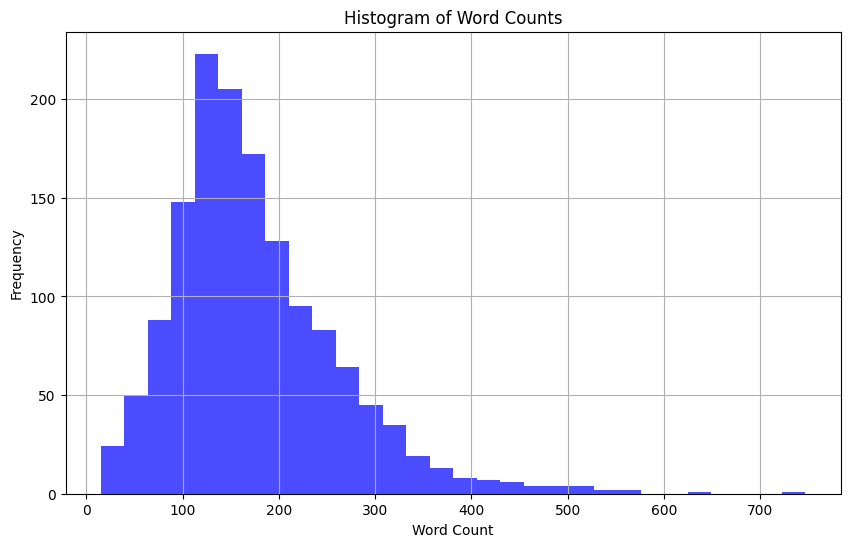

In [4]:
input_data_path = 'data/solubility.csv'
task_type = "classification"


df, n_labels = loading_data(input_data_path, task_type)
print(f'Number of labels: {n_labels}')
display(df)
# Function to count words in a summary
def word_count(summary):
    return len(summary.split())

# Apply the function to each summary and create a new column
df['Word_Count'] = df['Summary'].apply(word_count)

# Determine the median word count
median_count = df['Word_Count'].median()

# Function to categorize based on the median
def categorize_count(word_count):
    if word_count > median_count:
        return 'high count'
    else:
        return 'low count'

# Apply the categorization function
df['Count'] = df['Word_Count'].apply(categorize_count)

# Display the modified DataFrame
display(df)

# Calculate the minimum and maximum word counts
min_count = df['Word_Count'].min()
max_count = df['Word_Count'].max()

# Print median, minimum, and maximum word counts
print(f"Median word count: {median_count}")
print(f"Minimum word count: {min_count}")
print(f"Maximum word count: {max_count}")

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['Word_Count'], bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [12]:
df['Count'].value_counts()

Count
low count     721
high count    710
Name: count, dtype: int64

In [22]:
df = pd.read_csv('data/fine_solubility.csv', header= None, skiprows=[0])

# Reset the index if needed
df = df.reset_index(drop=True)
# Drop duplicates based on a subset of columns
df = df[df.iloc[:, 1:].duplicated(keep='first') == False]
# Reset the index if needed
df = df.reset_index(drop=True)
# Display the DataFrame
df

0         1         2         3         4         5     \
0              FES  0.977115 -0.056968 -0.014919 -0.353433  0.144711   
1           SLC7A7  0.997584  0.981466  0.657632 -0.289879  0.076314   
2            HSPA2  0.291824 -0.944040 -0.105381  0.205969 -0.125913   
3           ZSCAN9  0.706149 -0.852117 -0.009921  0.017956  0.043246   
4          SEPTIN3  0.987716  0.231037 -0.184549 -0.145114 -0.093823   
...            ...       ...       ...       ...       ...       ...   
13484  IQCJ-SCHIP1 -0.262526 -0.965565 -0.155519 -0.145781  0.263430   
13485        BPY2C  0.037251 -0.966223 -0.436817 -0.106845 -0.028248   
13486         DNER  0.929663 -0.535325  0.070750 -0.386048 -0.136483   
13487         SOX7  0.914309 -0.849164  0.096854 -0.079673  0.452759   
13488       CXCL14  0.712030 -0.750571 -0.021339  0.013732  0.337880   

           6         7         8         9     ...      1015      1016  \
0      0.128199 -0.991777 -0.412586  0.992094  ...  0.519316  0.033179   
1      0.161375 -0.915489 -0.129363  0.963075  ... -0.212308 -0.080988   
2     -0.329930 -0.515378 -0.188990  0.970557  ...  0.207481 -0.427193   
3      0.180170 -0.882911 -0.173601  0.970912  ...  0.326236 -0.361557   
4      0.307444 -0.288173 -0.197672  0.927474  ...  0.308460 -0.132265   
...         ...       ...       ...       ...  ...       ...       ...   
13484  0.211484 -0.873884 -0.271728  0.982986  ... -0.021413 -0.184269   
13485  0.030194 -0.876712  0.439705  0.909990  ...  0.341321 -0.448997   
13486  0.037117 -0.896040  0.158063  0.855398  ... -0.246519  0.182640   
13487  0.217703 -0.311517  0.182858  0.747946  ...  0.266952 -0.121453   
13488  0.008352 -0.266555 -0.174276  0.905332  ...  0.255149 -0.223871   

           1017      1018      1019      1020      1021      1022      1023  \
0     -0.999713 -0.008190  0.877587 -0.178617  0.989345 -0.407888 -0.032041   
1     -0.993670 -0.576222 -0.797116  0.168669 -0.978249 -0.428167  0.592644   
2     -0.973413  0.426451  0.982193 -0.147798  0.825458  0.024385 -0.172463   
3     -0.995700  0.019831  0.817748 -0.214124  0.510095 -0.050574  0.165245   
4     -0.993645  0.093128  0.901359  0.392338 -0.647371 -0.400882  0.046990   
...         ...       ...       ...       ...       ...       ...       ...   
13484 -0.959963  0.195860  0.973381 -0.088775  0.872142  0.006989  0.001523   
13485 -0.770019  0.144462  0.987026 -0.320866  0.975729 -0.005247 -0.048240   
13486 -0.988437 -0.373606  0.966674 -0.048342 -0.108672  0.171811 -0.184520   
13487 -0.961231 -0.167860  0.721643  0.006971  0.926839 -0.196857  0.278453   
13488 -0.953936  0.166707  0.729494 -0.272872  0.720646 -0.142772 -0.462755   

           1024  
0     -0.957704  
1     -0.989275  
2     -0.521153  
3     -0.582945  
4     -0.953763  
...         ...  
13484  0.468864  
13485  0.165216  
13486 -0.984165  
13487 -0.596787  
13488 -0.663508  

[13489 rows x 1025 columns]

In [23]:
df.to_csv('data/fine_solubility2.csv', index=False)